# In this notebook, LSTM Univariate & Multivariate models will be explored

In [163]:
%matplotlib inline

import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy import stats

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX

import tensorflow as tf
keras = tf.keras
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping

from sklearn.model_selection import train_test_split

# Always make it pretty.
plt.style.use('ggplot')

# We get some interger -> float typecast warning from sklean below, this keeps them out of our hair.
import warnings
warnings.filterwarnings('ignore')

import pickle
from datetime import datetime

## LSTM

#### Reload the data

The plan:

First run only price data to do a univariate LSTM ... DONE
Check results for all data including 2020 ... Poor Results

Check results for 2019 data only ... DONE, good results
Compare predictions with known 2020 data ... DONE dood results

Then do multivariate with price, offer qty and sold qty, for 1 tea category
Then add all categories

In [2]:
def get_timestamp():
    timestamp =   str(datetime.now().year) + '_'\
                + str(datetime.now().month).zfill(2) + '_'\
                + str(datetime.now().day).zfill(2) + '_'\
                + str(datetime.now().hour).zfill(2) + '_'\
                + str(datetime.now().minute).zfill(2) + '_'\
                + str(datetime.now().second).zfill(2)
    return timestamp

In [3]:
# load dataset
df_CHN_CTC_leaf = pd.read_csv('../Data/df_CHN_CTC_leaf.csv', header=0, index_col=0)
df_CHN_CTC_dust = pd.read_csv('../Data/df_CHN_CTC_dust.csv', header=0, index_col=0)
df_CHN_Ortho_leaf = pd.read_csv('../Data/df_CHN_Ortho_leaf.csv', header=0, index_col=0)
df_CHN_Ortho_dust = pd.read_csv('../Data/df_CHN_Ortho_dust.csv', header=0, index_col=0)

In [4]:
# # chop out 2020 data
# df_CHN_CTC_leaf = df_CHN_CTC_leaf[pd.to_datetime(df_CHN_CTC_leaf.index) < pd.to_datetime('2020-01-01')]
# df_CHN_CTC_dust = df_CHN_CTC_dust[pd.to_datetime(df_CHN_CTC_dust.index) < pd.to_datetime('2020-01-01')]
# df_CHN_Ortho_leaf = df_CHN_Ortho_leaf[pd.to_datetime(df_CHN_Ortho_leaf.index) < pd.to_datetime('2020-01-01')]
# df_CHN_Ortho_dust = df_CHN_Ortho_dust[pd.to_datetime(df_CHN_Ortho_dust.index) < pd.to_datetime('2020-01-01')]

In [5]:
def plot_oqty_sqty_avgp(df, category, city):

    fig, axs = plt.subplots(3, figsize=(15, 10))

    axs[0].plot(pd.to_datetime(df.index), df[category + '_offer_qty'],'*-', c='r',
                label=category.upper() + ' Offer Qty')
    axs[0].set_title(category.upper() + ' Offer Qty - ' + city)
    axs[0].set_ylabel('Kgs')
    axs[0].legend(loc='best')
    axs[0].tick_params(rotation=75, axis='x')
                            
    axs[1].plot(pd.to_datetime(df.index), df[category + '_sold_qty'], '*-', c='g',
                label=category.upper() + ' Sold Qty')
    axs[1].set_title(category.upper() + ' Sold Qty - ' + city)
    axs[1].set_ylabel('Kgs')
    axs[1].legend(loc='best')
    axs[1].tick_params(rotation=75, axis='x')
                            
    axs[2].plot(pd.to_datetime(df.index), df[category + '_avg_price'],'*-', c='b',
                label=category.upper() + ' Avg Price')
    axs[2].set_title(category.upper() + ' Avg Price - ' + city)
    axs[2].set_ylabel('Kgs')
    axs[2].legend(loc='best')
    axs[2].tick_params(rotation=75, axis='x')


    fig.tight_layout()
    fig.savefig('../Images/' + category.upper() + '_' + city + '_oqty_sqty_avgp' + get_timestamp())
                        
                        
# values = dataset.values
# # specify columns to plot
# groups = [0, 1, 2, 3, 5, 6, 7]
# i = 1
# # plot each column
# pyplot.figure()
# for group in groups:
# 	pyplot.subplot(len(groups), 1, i)
# 	pyplot.plot(values[:, group])
# 	pyplot.title(dataset.columns[group], y=0.5, loc='right')
# 	i += 1
# pyplot.show()

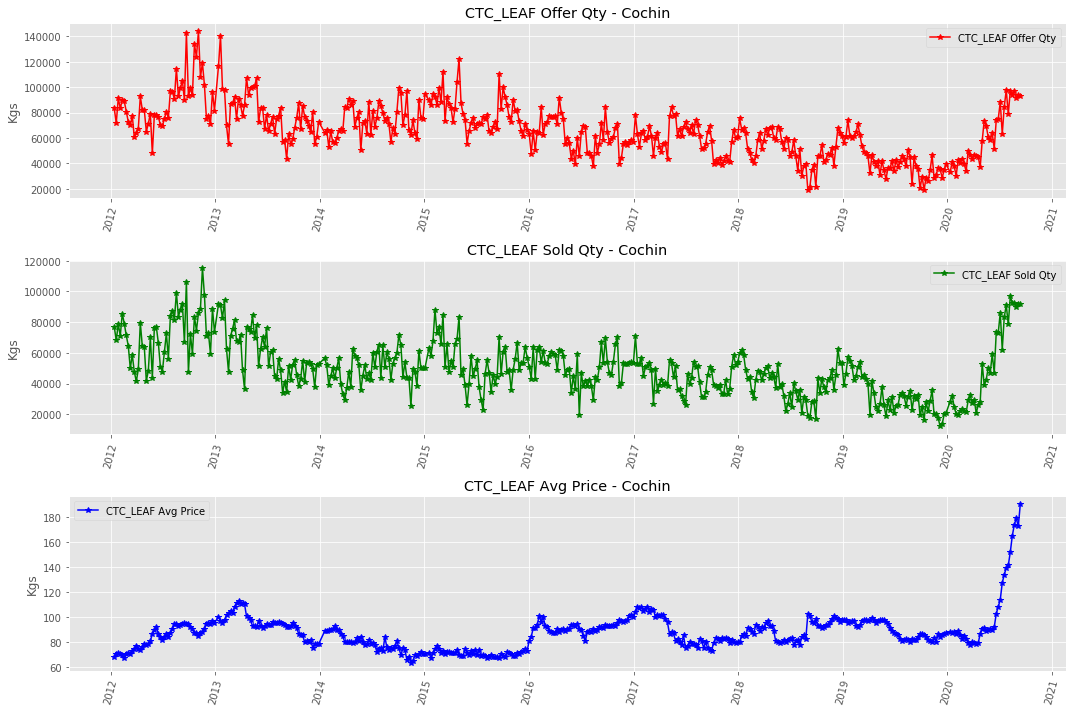

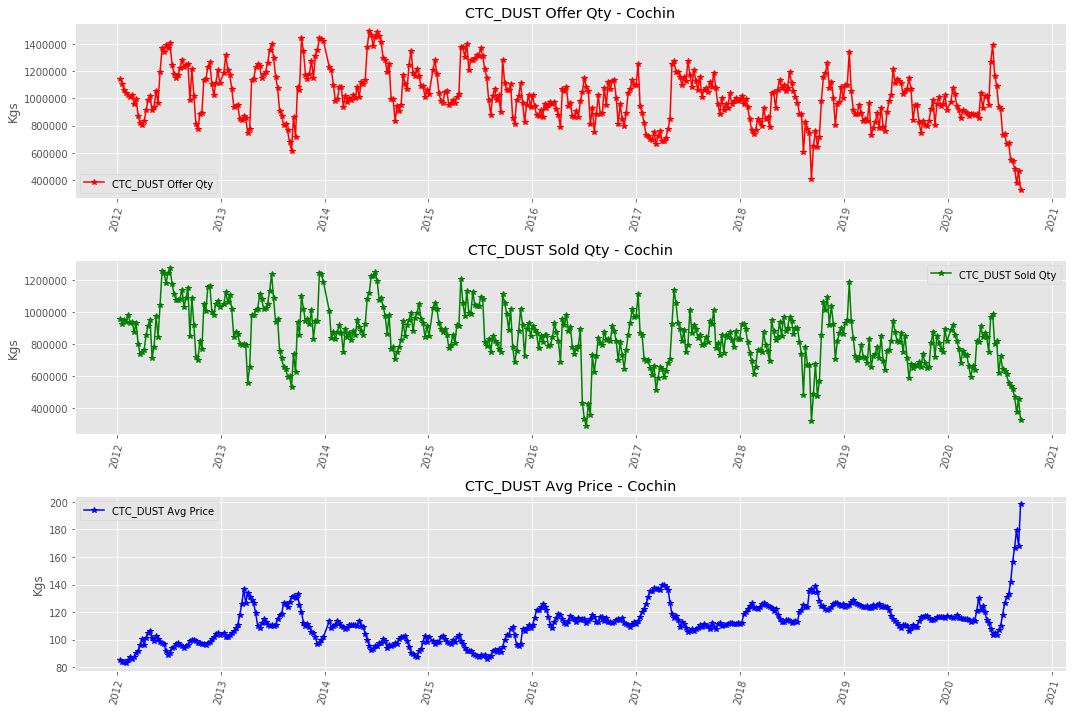

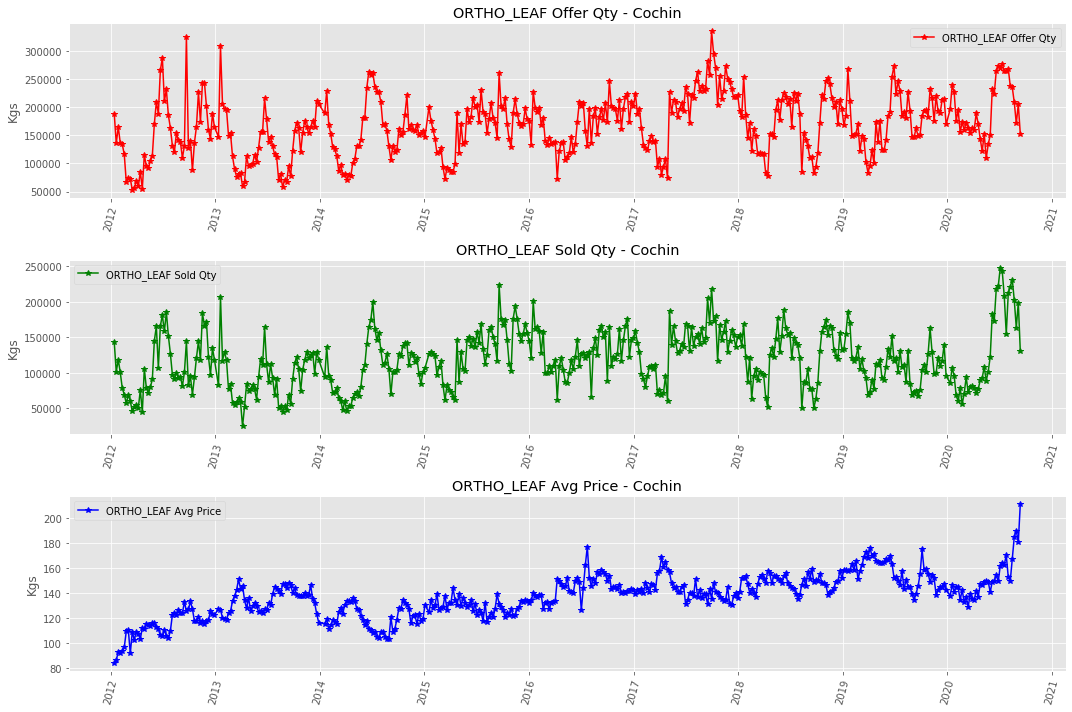

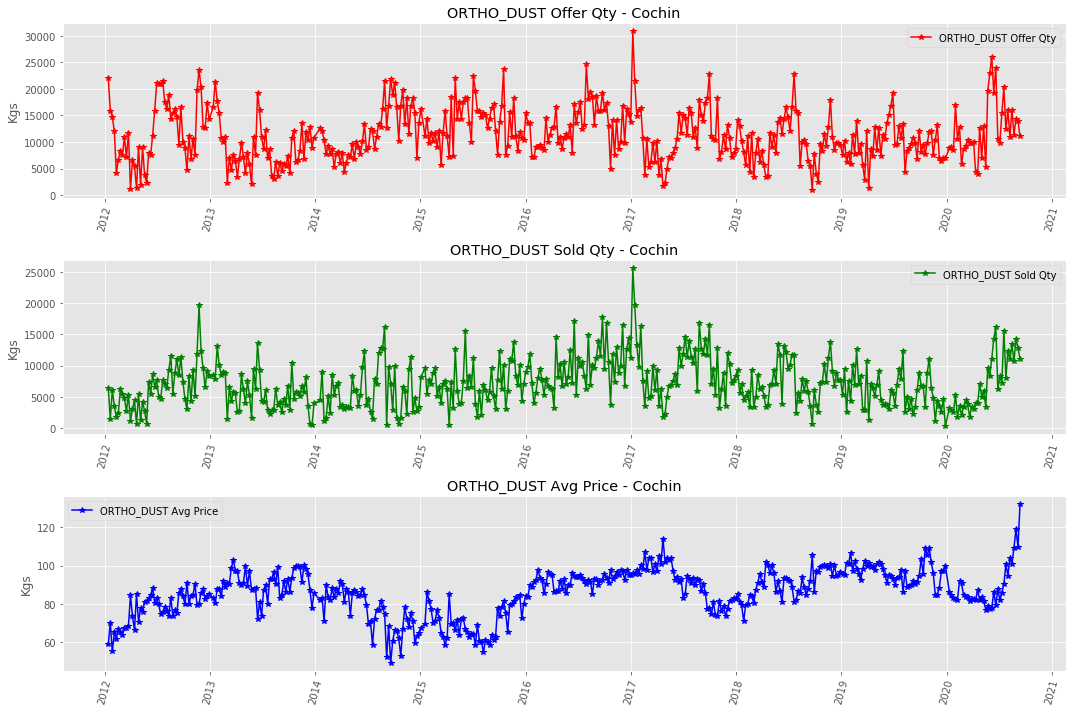

In [6]:
plot_oqty_sqty_avgp(df_CHN_CTC_leaf, 'ctc_leaf', 'Cochin')
plot_oqty_sqty_avgp(df_CHN_CTC_dust, 'ctc_dust', 'Cochin')
plot_oqty_sqty_avgp(df_CHN_Ortho_leaf, 'ortho_leaf', 'Cochin')
plot_oqty_sqty_avgp(df_CHN_Ortho_dust, 'ortho_dust', 'Cochin')

## Univariate

First we need to get the data into a format we can put into an RNN. Each training data point should consist of a sequence of consecutive values for our data (for input) and the next value of our data (for output).

First we'll write a function to consider every possible group of 52 values followed by one value (for the output) along our time-series data.

In [7]:
# Set up the first price series
price_series = df_CHN_CTC_leaf['ctc_leaf_avg_price']
time_series = price_series.index #pd.to_datetime(df_CHN_CTC_leaf['week_ending'])
# price_series.index = time_series
time_series

Index(['14-Jan-12', '21-Jan-12', '28-Jan-12', '4-Feb-12', '11-Feb-12',
       '18-Feb-12', '25-Feb-12', '3-Mar-12', '10-Mar-12', '17-Mar-12',
       ...
       '11-Jul-20', '18-Jul-20', '25-Jul-20', '1-Aug-20', '8-Aug-20',
       '15-Aug-20', '22-Aug-20', '29-Aug-20', '5-Sep-20', '12-Sep-20'],
      dtype='object', name='week_ending', length=448)

In [8]:
def windowize_data(data, n_prev):
    n_predictions = len(data) - n_prev
    y = data[n_prev:]
    # this might be too clever
    indices = np.arange(n_prev) + np.arange(n_predictions)[:, None]
    x = data[indices, None]
    return x, y

Then we'll write a function split the data into training and testing sets. Because it's time-series data we have to do that sequentially rather than shuffling it. They should be completely separate and not overlap, so the the training data isn't used for testing.

In [9]:
def split_and_windowize(data, n_prev, fraction_test=0.05):
    n_predictions = len(data) - 2*n_prev
    
    n_test  = int(fraction_test * n_predictions)
    n_train = n_predictions - n_test   
    
    x_train, y_train = windowize_data(data[:n_train], n_prev)
    x_test, y_test = windowize_data(data[n_train:], n_prev)
    return x_train, x_test, y_train, y_test

In [10]:
df_CHN_CTC_leaf

year  serial_no  ctc_leaf_offer_qty  ctc_leaf_sold_qty  \
week_ending                                                           
14-Jan-12    2012          2            83325.00           77015.00   
21-Jan-12    2012          3            71897.00           68187.00   
28-Jan-12    2012          4            91279.00           78695.00   
4-Feb-12     2012          5            83746.00           71188.00   
11-Feb-12    2012          6            89650.00           85480.00   
...           ...        ...                 ...                ...   
15-Aug-20    2020         33            93637.00           92640.00   
22-Aug-20    2020         34            96829.00           92338.00   
29-Aug-20    2020         35            91799.00           89785.00   
5-Sep-20     2020         36            94088.33           91587.67   
12-Sep-20    2020         37            93485.00           91607.00   

             ctc_leaf_avg_price  
week_ending                      
14-Jan-12                 68.03  
21-Jan-12                 70.11  
28-Jan-12                 70.73  
4-Feb-12                  70.63  
11-Feb-12                 69.23  
...                         ...  
15-Aug-20                165.10  
22-Aug-20                174.03  
29-Aug-20                179.36  
5-Sep-20                 172.83  
12-Sep-20                190.66  

[448 rows x 5 columns]

In [11]:
n_prev = 6

x_train, x_test, y_train, y_test = split_and_windowize(price_series.values, n_prev)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

# ((363, 10, 3), (29, 10, 3), (363, 3), (29, 3))

((409, 6, 1), (27, 6, 1), (409,), (27,))

One of the difficulties with traditional RNNs is what's called the "vanishing gradients problem." For neural networks (this is 50 levels deep!) the effect of the input at the beginning exponentially shrinks with the depth of the network. This makes it very hard to remember details from the disThe the signal from each successively earlier point is typically smaller (or maybe larger) than the previous is that while they can "remember" what happened recently, 

There are other architectures of RNNs that will do a better job. One is a Long Short Term Memory (LSTM) network; a good post detailing them is at [http://colah.github.io/posts/2015-08-Understanding-LSTMs/]

In [12]:
# LSTM_price_model = keras.Sequential()

# LSTM_price_model.add(keras.layers.LSTM(52, input_shape=(n_prev, 1), return_sequences=True))

# LSTM_price_model.add(keras.layers.LSTM(52, return_sequences=False))

# LSTM_price_model.add(keras.layers.Dense(1, activation='relu')) # 'linear'

# LSTM_price_model.compile(optimizer='adam', loss='mse')

In [13]:
LSTM_price_model = keras.Sequential()

LSTM_price_model.add(keras.layers.LSTM(52, input_shape=(n_prev, 1), return_sequences=True))

LSTM_price_model.add(keras.layers.Dropout(0.1))

LSTM_price_model.add(keras.layers.LSTM(52, return_sequences=False))

LSTM_price_model.add(keras.layers.Dense(1, activation='relu')) # 'linear'

LSTM_price_model.compile(optimizer='adam', loss='mse')

In [14]:
LSTM_price_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 6, 52)             11232     
_________________________________________________________________
dropout (Dropout)            (None, 6, 52)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 52)                21840     
_________________________________________________________________
dense (Dense)                (None, 1)                 53        
Total params: 33,125
Trainable params: 33,125
Non-trainable params: 0
_________________________________________________________________


In [15]:
LSTM_price_model_history = LSTM_price_model.fit(x_train, y_train, batch_size=10, epochs=5000)


Epoch 1/5000
41/41 [==============================] - 0s 5ms/step - loss: 6811.0063
Epoch 2/5000
41/41 [==============================] - 0s 4ms/step - loss: 5613.8281
Epoch 3/5000
41/41 [==============================] - 0s 4ms/step - loss: 5143.7715
Epoch 4/5000
41/41 [==============================] - 0s 4ms/step - loss: 4801.5566
Epoch 5/5000
41/41 [==============================] - 0s 4ms/step - loss: 4491.6719
Epoch 6/5000
41/41 [==============================] - 0s 4ms/step - loss: 4205.3662
Epoch 7/5000
41/41 [==============================] - 0s 4ms/step - loss: 3937.0000
Epoch 8/5000
41/41 [==============================] - 0s 4ms/step - loss: 3684.6746
Epoch 9/5000
41/41 [==============================] - 0s 4ms/step - loss: 3446.8457
Epoch 10/5000
41/41 [==============================] - 0s 4ms/step - loss: 3222.6262
Epoch 11/5000
41/41 [==============================] - 0s 4ms/step - loss: 3010.6877
Epoch 12/5000
41/41 [==============================] - 0s 4ms/step - loss:

41/41 [==============================] - 0s 4ms/step - loss: 109.4120
Epoch 99/5000
41/41 [==============================] - 0s 4ms/step - loss: 109.3741
Epoch 100/5000
41/41 [==============================] - 0s 4ms/step - loss: 109.1054
Epoch 101/5000
41/41 [==============================] - 0s 4ms/step - loss: 94.1468
Epoch 102/5000
41/41 [==============================] - 0s 4ms/step - loss: 72.2591
Epoch 103/5000
41/41 [==============================] - 0s 4ms/step - loss: 59.8047
Epoch 104/5000
41/41 [==============================] - 0s 4ms/step - loss: 53.8452
Epoch 105/5000
41/41 [==============================] - 0s 4ms/step - loss: 48.1252
Epoch 106/5000
41/41 [==============================] - 0s 4ms/step - loss: 45.2841
Epoch 107/5000
41/41 [==============================] - 0s 4ms/step - loss: 42.8891
Epoch 108/5000
41/41 [==============================] - 0s 4ms/step - loss: 39.1333
Epoch 109/5000
41/41 [==============================] - 0s 4ms/step - loss: 34.1370
Epoch

41/41 [==============================] - 0s 4ms/step - loss: 11.3443
Epoch 196/5000
41/41 [==============================] - 0s 4ms/step - loss: 10.7371
Epoch 197/5000
41/41 [==============================] - 0s 4ms/step - loss: 11.5506
Epoch 198/5000
41/41 [==============================] - 0s 4ms/step - loss: 11.7005
Epoch 199/5000
41/41 [==============================] - 0s 4ms/step - loss: 11.2002
Epoch 200/5000
41/41 [==============================] - 0s 4ms/step - loss: 12.1349
Epoch 201/5000
41/41 [==============================] - 0s 4ms/step - loss: 11.7775
Epoch 202/5000
41/41 [==============================] - 0s 4ms/step - loss: 12.3391
Epoch 203/5000
41/41 [==============================] - 0s 4ms/step - loss: 12.0522
Epoch 204/5000
41/41 [==============================] - 0s 4ms/step - loss: 11.6908
Epoch 205/5000
41/41 [==============================] - 0s 4ms/step - loss: 11.0706
Epoch 206/5000
41/41 [==============================] - 0s 4ms/step - loss: 11.7329
Epoch 2

41/41 [==============================] - 0s 4ms/step - loss: 10.2621
Epoch 293/5000
41/41 [==============================] - 0s 4ms/step - loss: 10.4615
Epoch 294/5000
41/41 [==============================] - 0s 4ms/step - loss: 10.7757
Epoch 295/5000
41/41 [==============================] - 0s 4ms/step - loss: 11.3140
Epoch 296/5000
41/41 [==============================] - 0s 4ms/step - loss: 10.7703
Epoch 297/5000
41/41 [==============================] - 0s 4ms/step - loss: 10.6102
Epoch 298/5000
41/41 [==============================] - 0s 4ms/step - loss: 10.9250
Epoch 299/5000
41/41 [==============================] - 0s 4ms/step - loss: 10.8345
Epoch 300/5000
41/41 [==============================] - 0s 4ms/step - loss: 10.0246
Epoch 301/5000
41/41 [==============================] - 0s 4ms/step - loss: 10.4941
Epoch 302/5000
41/41 [==============================] - 0s 4ms/step - loss: 9.8122
Epoch 303/5000
41/41 [==============================] - 0s 4ms/step - loss: 9.8324
Epoch 304

KeyboardInterrupt: 

In [18]:
# ## Pickle the model
# # Save the Modle to file in the current working directory
# timestamp =   str(datetime.now().year) + '_'\
#             + str(datetime.now().month).zfill(2) + '_'\
#             + str(datetime.now().day).zfill(2) + '_'\
#             + str(datetime.now().hour).zfill(2) + '_'\
#             + str(datetime.now().minute).zfill(2) + '_'\
#             + str(datetime.now().second).zfill(2)


# pickled_model_filename = '../Models/LSTM_price_model_' + LSTM_price_model.name + '_' + timestamp + '.pkl'  

# with open(pickled_model_filename, 'wb') as file:  
#     pickle.dump(LSTM_price_model, file)

# # Load the Model back from file
# with open(pickled_model_filename, 'rb') as file:  
#     pickled_LSTM_price_model = pickle.load(file)

# pickled_LSTM_price_model

## Predictions from LSTM Univariate

In [16]:
y_pred = LSTM_price_model.predict(x_test)
y_pred

array([[ 82.90148 ],
       [ 80.55401 ],
       [ 78.56359 ],
       [ 79.0925  ],
       [ 79.406235],
       [ 79.19218 ],
       [ 79.03779 ],
       [ 84.94677 ],
       [ 90.8912  ],
       [ 93.06149 ],
       [ 90.247765],
       [ 90.215706],
       [ 91.60102 ],
       [ 91.237946],
       [ 92.447876],
       [ 98.56155 ],
       [105.16047 ],
       [108.108215],
       [108.454185],
       [108.495674],
       [108.50513 ],
       [108.49851 ],
       [108.477745],
       [108.45459 ],
       [108.4198  ],
       [108.36894 ],
       [108.27438 ]], dtype=float32)

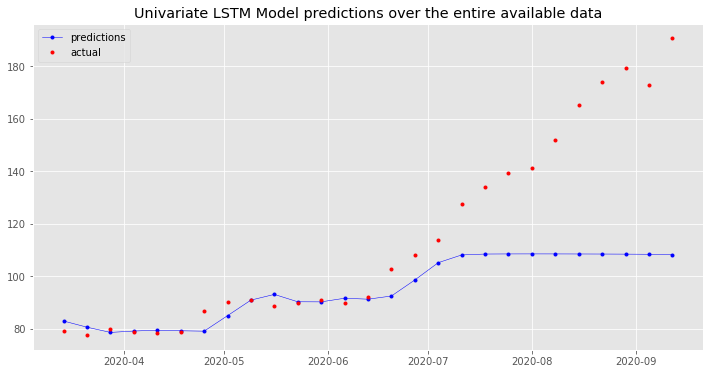

In [17]:
# Plot the predictions (one step ahead) against the test data
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(pd.to_datetime(time_series[-len(y_pred):]), y_pred, 'b.-', label='predictions', lw=0.5)
ax.plot(pd.to_datetime(time_series[-len(y_pred):]), y_test, 'r.', label='actual')
ax.set_title('Univariate LSTM Model predictions over the entire available data')
fig.savefig('../Images/UnivariateLSTMModelPredictions_testdata_entire_available' + get_timestamp())
ax.legend();

In [18]:
# Calculating MAPE (Mean Absolute Precentage Error)
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [19]:
# Calaculate MAPE
print(f'MAPE for known data (before 2020) = {mape(price_series, y_pred)}')

MAPE for known data (before 2020) = 18.899803386692117


In [20]:
LSTM_price_model_history.history

NameError: name 'LSTM_price_model_history' is not defined

In [24]:
def plot_train_history(history, title):
    loss = history.history['loss']
#     val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure(figsize=(20,10))

    plt.plot(epochs, loss, 'b', label='Training loss')
#     plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()


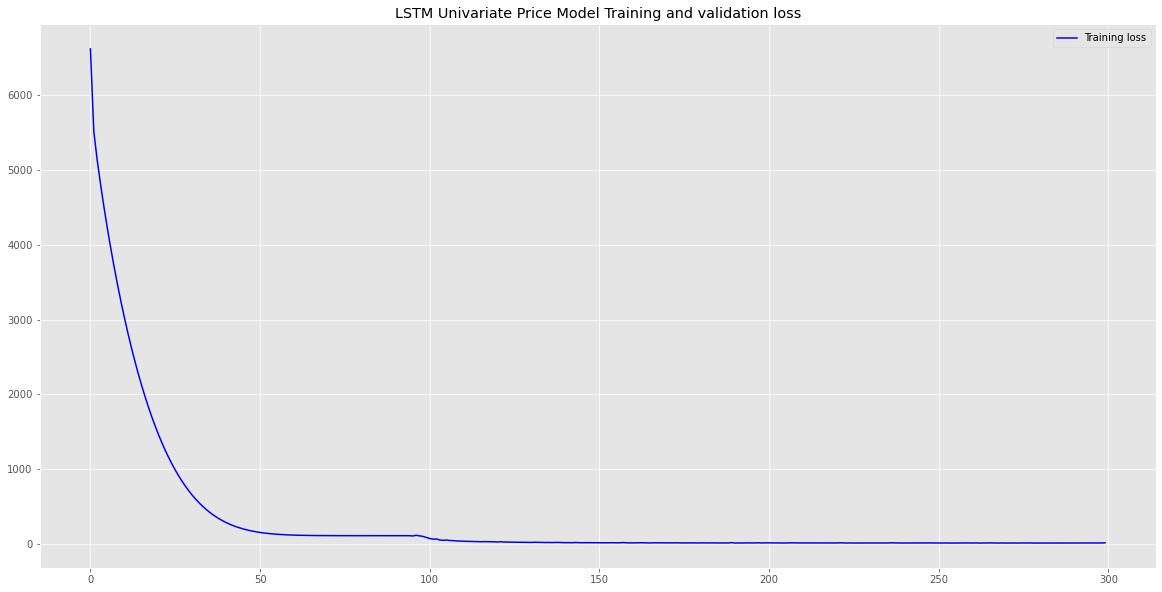

In [25]:
plot_train_history(LSTM_price_model_history, 'LSTM Univariate Price Model Training and validation loss')

In [27]:
288 * 10000 /300000

9.6

## Try again with scaled data

In [21]:
# Data Loader Parameters
BATCH_SIZE = 52
BUFFER_SIZE = 10 # 10000
TRAIN_SPLIT = 288 # ~ 70:30 300K out of 420K

# LSTM Parameters
EVALUATION_INTERVAL = 200
EPOCHS = 1000
PATIENCE = 100

# Reproducibility
SEED = 13
# tf.random.set_seed(SEED)

n_prev = 6


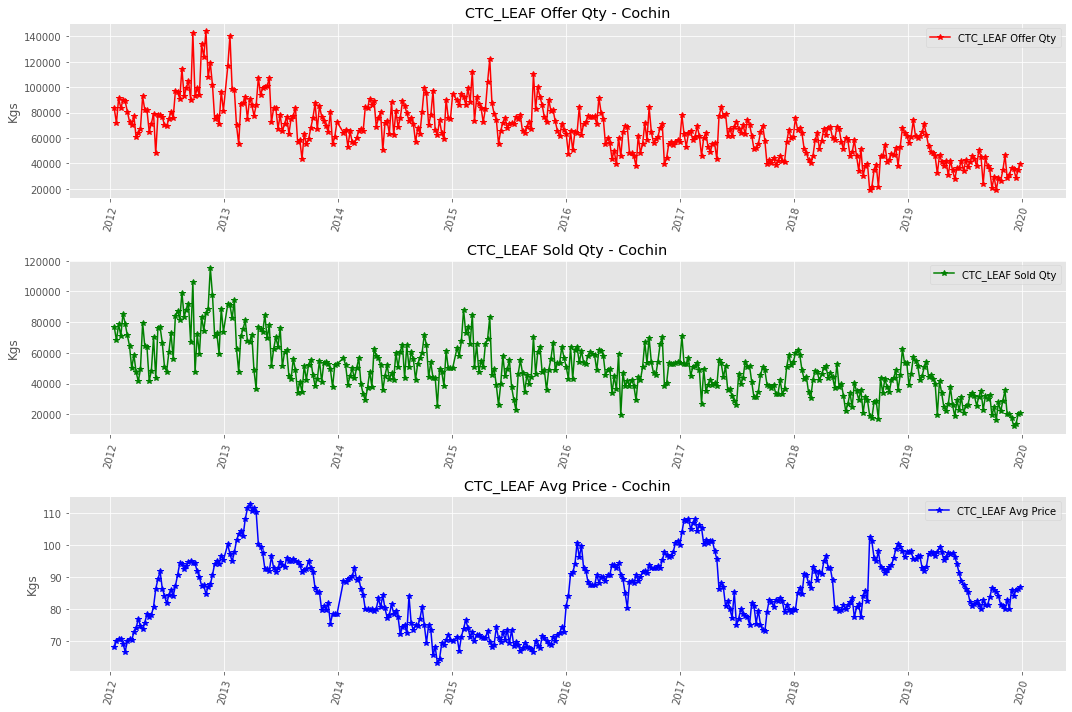

In [22]:
# Load the data again
df_CHN_CTC_leaf = pd.read_csv('../Data/df_CHN_CTC_leaf.csv', header=0, index_col=0)
# # chop out 2020 data
df_CHN_CTC_leaf = df_CHN_CTC_leaf[pd.to_datetime(df_CHN_CTC_leaf.index) < pd.to_datetime('2020-01-01')]
# Plot it
plot_oqty_sqty_avgp(df_CHN_CTC_leaf, 'ctc_leaf', 'Cochin')

In [23]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
        
    return np.array(data), np.array(labels)


In [24]:
df_CHN_CTC_leaf.info()


<class 'pandas.core.frame.DataFrame'>
Index: 412 entries, 14-Jan-12 to 28-Dec-19
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                412 non-null    int64  
 1   serial_no           412 non-null    int64  
 2   ctc_leaf_offer_qty  412 non-null    float64
 3   ctc_leaf_sold_qty   412 non-null    float64
 4   ctc_leaf_avg_price  412 non-null    float64
dtypes: float64(3), int64(2)
memory usage: 19.3+ KB


In [25]:
# Prepare the data for only the average price

In [26]:
uni_data = df_CHN_CTC_leaf['ctc_leaf_avg_price']
uni_data.index = df_CHN_CTC_leaf.index

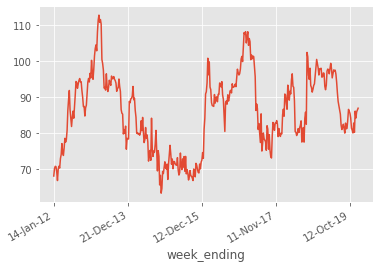

In [27]:
uni_data.plot(subplots=True)
plt.show()
uni_data = uni_data.values

In [28]:
# Scale only the train data
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [29]:
# Create the data for the univariate model which will be given the last n_prev weeks' price observations, 
# and needs to learn to predict the temperature at the next week.
univariate_past_history = n_prev
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(dataset=uni_data,
                                           start_index=0,
                                           end_index=TRAIN_SPLIT,
                                           history_size=univariate_past_history,
                                           target_size=univariate_future_target)
x_val_uni, y_val_uni = univariate_data(dataset=uni_data,
                                       start_index=TRAIN_SPLIT,
                                       end_index=None,
                                       history_size=univariate_past_history,
                                       target_size=univariate_future_target)

In [30]:
print("In:")
print(uni_data.shape)
print(uni_data[:5])

print("\nOut")
print(x_train_uni.shape)


print(x_train_uni.shape[0] / uni_data.shape[0])

In:
(412,)
[-1.44628993 -1.26760032 -1.21433707 -1.22292792 -1.34319977]

Out
(282, 6, 1)
0.6844660194174758


In [31]:
print ('Single window of past history. Shape: {}'.format(x_train_uni[0].shape))
print (x_train_uni[0])
print ('\n Target temperature to predict. Shape: {}'.format(y_train_uni[0].shape))
print (y_train_uni[0])

Single window of past history. Shape: (6, 1)
[[-1.44628993]
 [-1.26760032]
 [-1.21433707]
 [-1.22292792]
 [-1.34319977]
 [-1.5545346 ]]

 Target temperature to predict. Shape: ()
-1.2839229297660377


In [32]:
def create_time_steps(length):
    return list(range(-length, 0))

In [33]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                   label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
        plt.legend()
        plt.xlim([time_steps[0], (future+5)*2])
        plt.xlabel('Time-Step')
    
    return plt

<module 'matplotlib.pyplot' from '/home/ubuntu/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

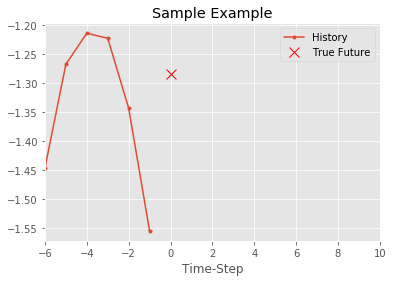

In [34]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

#### Baseline
Before proceeding to train a model, let's first set a simple baseline. Given an input point, the baseline method looks at all the history and predicts the next point to be the average of the last 20 observations.

In [35]:
def baseline(history):
    return np.mean(history)

<module 'matplotlib.pyplot' from '/home/ubuntu/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

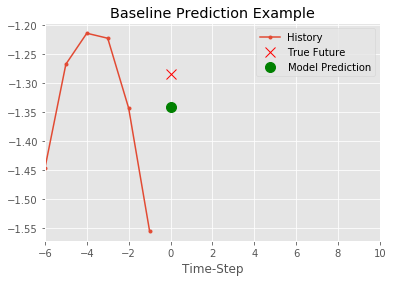

In [36]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

In [37]:
# Let's now use tf.data to shuffle, batch, and cache the dataset.
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [38]:
x_train_uni.shape

(282, 6, 1)

In [39]:
# Set up the model
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mape')

In [40]:
# LSTM_price_model = keras.Sequential()
# LSTM_price_model.add(keras.layers.LSTM(52, input_shape=(n_prev, 1), return_sequences=True))
# LSTM_price_model.add(keras.layers.Dropout(0.1))
# LSTM_price_model.add(keras.layers.LSTM(52, return_sequences=False))
# LSTM_price_model.add(keras.layers.Dense(1, activation='relu')) # 'linear'

# LSTM_price_model.compile(optimizer='adam', loss='mse')

In [41]:
for x, y in val_univariate.take(1):
    
    print(simple_lstm_model.predict(x).shape)

(52, 1)


In [42]:
tf.__version__

'2.3.0'

In [43]:
# train the model
early_stopping = EarlyStopping(monitor='val_loss', patience = 500, restore_best_weights=True)
simple_lstm_model.fit(train_univariate,
                      epochs=500,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate,
                      callbacks=[early_stopping],
                      validation_steps=50)

Epoch 1/500
200/200 [==============================] - 1s 4ms/step - loss: 103.6736 - val_loss: 122.7850
Epoch 2/500
200/200 [==============================] - 0s 2ms/step - loss: 87.2208 - val_loss: 118.4497
Epoch 3/500
200/200 [==============================] - 0s 2ms/step - loss: 85.4936 - val_loss: 118.1858
Epoch 4/500
200/200 [==============================] - 0s 2ms/step - loss: 83.1432 - val_loss: 116.7455
Epoch 5/500
200/200 [==============================] - 0s 2ms/step - loss: 81.3124 - val_loss: 110.1286
Epoch 6/500
200/200 [==============================] - 0s 2ms/step - loss: 80.2504 - val_loss: 103.8844
Epoch 7/500
200/200 [==============================] - 0s 2ms/step - loss: 78.8879 - val_loss: 97.8370
Epoch 8/500
200/200 [==============================] - 0s 2ms/step - loss: 77.4497 - val_loss: 93.9556
Epoch 9/500
200/200 [==============================] - 0s 2ms/step - loss: 77.1169 - val_loss: 93.3887
Epoch 10/500
200/200 [==============================] - 0s 2ms/ste

200/200 [==============================] - 0s 2ms/step - loss: 52.2821 - val_loss: 93.8603
Epoch 80/500
200/200 [==============================] - 0s 2ms/step - loss: 51.8995 - val_loss: 93.6602
Epoch 81/500
200/200 [==============================] - 0s 2ms/step - loss: 51.9602 - val_loss: 93.5466
Epoch 82/500
200/200 [==============================] - 0s 2ms/step - loss: 51.7133 - val_loss: 93.1834
Epoch 83/500
200/200 [==============================] - 0s 2ms/step - loss: 51.5256 - val_loss: 93.0862
Epoch 84/500
200/200 [==============================] - 0s 2ms/step - loss: 51.2973 - val_loss: 92.7199
Epoch 85/500
200/200 [==============================] - 0s 2ms/step - loss: 51.1621 - val_loss: 92.3791
Epoch 86/500
200/200 [==============================] - 0s 2ms/step - loss: 50.7714 - val_loss: 91.8962
Epoch 87/500
200/200 [==============================] - 0s 2ms/step - loss: 50.8929 - val_loss: 91.9611
Epoch 88/500
200/200 [==============================] - 0s 2ms/step - loss: 5

200/200 [==============================] - 0s 2ms/step - loss: 41.6584 - val_loss: 89.3446
Epoch 158/500
200/200 [==============================] - 0s 2ms/step - loss: 41.8395 - val_loss: 89.4636
Epoch 159/500
200/200 [==============================] - 0s 2ms/step - loss: 41.3096 - val_loss: 89.7505
Epoch 160/500
200/200 [==============================] - 0s 2ms/step - loss: 41.3346 - val_loss: 89.7779
Epoch 161/500
200/200 [==============================] - 0s 2ms/step - loss: 41.1146 - val_loss: 90.4897
Epoch 162/500
200/200 [==============================] - 0s 2ms/step - loss: 41.1314 - val_loss: 90.7041
Epoch 163/500
200/200 [==============================] - 0s 2ms/step - loss: 41.4201 - val_loss: 90.8091
Epoch 164/500
200/200 [==============================] - 0s 2ms/step - loss: 40.8251 - val_loss: 90.7837
Epoch 165/500
200/200 [==============================] - 0s 2ms/step - loss: 40.7789 - val_loss: 90.7178
Epoch 166/500
200/200 [==============================] - 0s 2ms/step 

200/200 [==============================] - 0s 2ms/step - loss: 35.1660 - val_loss: 95.9051
Epoch 236/500
200/200 [==============================] - 0s 2ms/step - loss: 34.7430 - val_loss: 95.9144
Epoch 237/500
200/200 [==============================] - 0s 2ms/step - loss: 34.6679 - val_loss: 95.6898
Epoch 238/500
200/200 [==============================] - 0s 2ms/step - loss: 35.0537 - val_loss: 95.3642
Epoch 239/500
200/200 [==============================] - 0s 2ms/step - loss: 34.8948 - val_loss: 95.2614
Epoch 240/500
200/200 [==============================] - 0s 2ms/step - loss: 34.5795 - val_loss: 95.4019
Epoch 241/500
200/200 [==============================] - 0s 2ms/step - loss: 34.4755 - val_loss: 95.0381
Epoch 242/500
200/200 [==============================] - 0s 2ms/step - loss: 34.5063 - val_loss: 95.2157
Epoch 243/500
200/200 [==============================] - 0s 2ms/step - loss: 34.5160 - val_loss: 95.0314
Epoch 244/500
200/200 [==============================] - 0s 2ms/step 

200/200 [==============================] - 0s 2ms/step - loss: 28.2945 - val_loss: 103.2642
Epoch 314/500
200/200 [==============================] - 0s 2ms/step - loss: 28.1689 - val_loss: 102.4095
Epoch 315/500
200/200 [==============================] - 0s 2ms/step - loss: 28.5489 - val_loss: 102.9415
Epoch 316/500
200/200 [==============================] - 0s 2ms/step - loss: 28.0531 - val_loss: 102.6715
Epoch 317/500
200/200 [==============================] - 0s 2ms/step - loss: 27.9057 - val_loss: 102.5212
Epoch 318/500
200/200 [==============================] - 0s 2ms/step - loss: 27.7572 - val_loss: 104.0778
Epoch 319/500
200/200 [==============================] - 0s 2ms/step - loss: 27.5811 - val_loss: 103.9661
Epoch 320/500
200/200 [==============================] - 0s 2ms/step - loss: 27.5854 - val_loss: 103.9561
Epoch 321/500
200/200 [==============================] - 0s 2ms/step - loss: 27.4171 - val_loss: 103.2951
Epoch 322/500
200/200 [==============================] - 0s 

200/200 [==============================] - 0s 2ms/step - loss: 22.0988 - val_loss: 113.2674
Epoch 391/500
200/200 [==============================] - 0s 2ms/step - loss: 21.2701 - val_loss: 113.6993
Epoch 392/500
200/200 [==============================] - 0s 2ms/step - loss: 21.1463 - val_loss: 113.5006
Epoch 393/500
200/200 [==============================] - 0s 2ms/step - loss: 21.0528 - val_loss: 112.9019
Epoch 394/500
200/200 [==============================] - 0s 2ms/step - loss: 21.1161 - val_loss: 113.2276
Epoch 395/500
200/200 [==============================] - 0s 2ms/step - loss: 21.6535 - val_loss: 113.5866
Epoch 396/500
200/200 [==============================] - 0s 2ms/step - loss: 20.9578 - val_loss: 113.7890
Epoch 397/500
200/200 [==============================] - 0s 2ms/step - loss: 20.8677 - val_loss: 113.8832
Epoch 398/500
200/200 [==============================] - 0s 2ms/step - loss: 20.7647 - val_loss: 113.8976
Epoch 399/500
200/200 [==============================] - 0s 

200/200 [==============================] - 0s 2ms/step - loss: 19.5847 - val_loss: 120.3068
Epoch 468/500
200/200 [==============================] - 0s 2ms/step - loss: 18.7384 - val_loss: 119.5340
Epoch 469/500
200/200 [==============================] - 0s 2ms/step - loss: 18.6457 - val_loss: 120.2489
Epoch 470/500
200/200 [==============================] - 0s 2ms/step - loss: 18.6136 - val_loss: 120.7991
Epoch 471/500
200/200 [==============================] - 0s 2ms/step - loss: 19.4680 - val_loss: 122.4164
Epoch 472/500
200/200 [==============================] - 0s 2ms/step - loss: 19.4654 - val_loss: 122.4177
Epoch 473/500
200/200 [==============================] - 0s 2ms/step - loss: 19.5522 - val_loss: 121.3462
Epoch 474/500
200/200 [==============================] - 0s 2ms/step - loss: 19.4978 - val_loss: 121.4776
Epoch 475/500
200/200 [==============================] - 0s 2ms/step - loss: 19.5223 - val_loss: 121.2445
Epoch 476/500
200/200 [==============================] - 0s 

### Predict

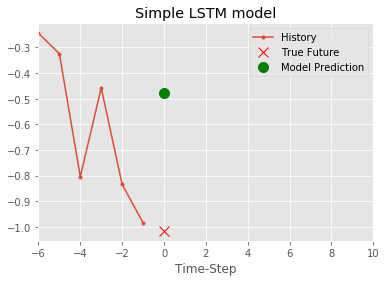

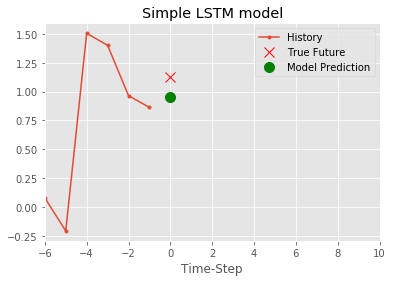

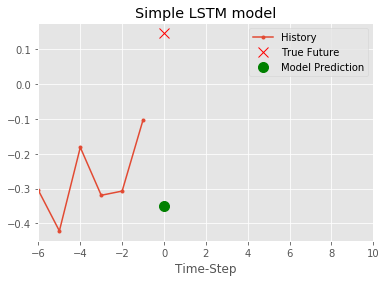

In [46]:
for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()

#### Poor results for univariate!

## Multivariate

In [117]:
# Data Loader Parameters
BATCH_SIZE = 52
BUFFER_SIZE = 10 # 10000
TRAIN_SPLIT = 288 # ~ 70:30 300K out of 420K

# Reproducibility
SEED = 13
# tf.random.set_seed(SEED)

n_prev = 52


First for 3 features from the same tea category (CTC Leaf): ctc_leaf_avg_price, ctc_leaf_offer_qty & ctc_leaf_sold_qty.

In [118]:
features_considered = ['ctc_leaf_sold_qty', 'ctc_leaf_avg_price', 'ctc_leaf_offer_qty']

In [119]:
features = df_CHN_CTC_leaf[features_considered]
features.index = df_CHN_CTC_leaf.index
features.head()

ctc_leaf_sold_qty  ctc_leaf_avg_price  ctc_leaf_offer_qty
week_ending                                                           
14-Jan-12              77015.0               68.03             83325.0
21-Jan-12              68187.0               70.11             71897.0
28-Jan-12              78695.0               70.73             91279.0
4-Feb-12               71188.0               70.63             83746.0
11-Feb-12              85480.0               69.23             89650.0

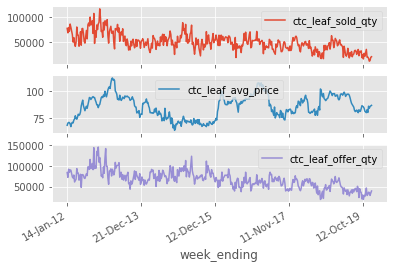

In [120]:
features.plot(subplots=True);

Standardize the dataset using the mean and standard deviation of the training data.

In [121]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

In [122]:
pd.DataFrame(dataset, columns = features.columns, index= features.index).head()

ctc_leaf_sold_qty  ctc_leaf_avg_price  ctc_leaf_offer_qty
week_ending                                                           
14-Jan-12             1.357758           -1.446290            0.468435
21-Jan-12             0.796453           -1.267600           -0.183496
28-Jan-12             1.464576           -1.214337            0.922186
4-Feb-12              0.987264           -1.222928            0.492452
11-Feb-12             1.895982           -1.343200            0.829257

#### Single step model
In a single step setup, the model learns to predict a single point in the future based on some history provided.

The below function performs the windowing task as below, however, here it samples the past observation based on the step size given.

In [123]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

The model is shown data from the last n_prev weeks.
For the single step prediction model, the label for a datapoint is the price 1 weeks into the future. 

In [124]:
past_history = n_prev # 6 weeks .... 720
future_target = 1 # after 3 weeks   .... 72
STEP = 1 # ... 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

Let's look at a single data-point.

In [125]:
print(x_train_single.shape)
print ('Single window of past history : {}'.format(x_train_single[0].shape))
print(x_train_single.shape[-2:])

(236, 52, 3)
Single window of past history : (52, 3)
(52, 3)


In [126]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [127]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mape')

Let's check out a sample prediction.

In [128]:
for x, y in val_data_single.take(1):
    print(single_step_model.predict(x).shape)

(52, 1)


In [129]:
# LSTM Parameters
EVALUATION_INTERVAL = 200
EPOCHS = 100
PATIENCE = 100

In [130]:
print(f"Evaluation Threshold: {EVALUATION_INTERVAL}",
      f"Epochs: {EPOCHS}", sep="\n")

early_stopping = EarlyStopping(monitor='val_loss', patience = PATIENCE, restore_best_weights=True)
single_step_history = single_step_model.fit(train_data_single,
                                            epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            callbacks=[early_stopping],
                                            validation_steps=50)

Evaluation Threshold: 200
Epochs: 100
Epoch 1/100
200/200 [==============================] - 3s 16ms/step - loss: 93.3513 - val_loss: 126.6463
Epoch 2/100
200/200 [==============================] - 3s 14ms/step - loss: 78.2238 - val_loss: 107.9697
Epoch 3/100
200/200 [==============================] - 3s 14ms/step - loss: 68.5909 - val_loss: 106.0153
Epoch 4/100
200/200 [==============================] - 3s 14ms/step - loss: 63.4440 - val_loss: 91.7123
Epoch 5/100
200/200 [==============================] - 3s 14ms/step - loss: 61.4357 - val_loss: 94.9101
Epoch 6/100
200/200 [==============================] - 3s 14ms/step - loss: 58.9004 - val_loss: 88.2153
Epoch 7/100
200/200 [==============================] - 3s 14ms/step - loss: 56.0397 - val_loss: 84.4964
Epoch 8/100
200/200 [==============================] - 3s 14ms/step - loss: 52.4929 - val_loss: 85.4753
Epoch 9/100
200/200 [==============================] - 3s 14ms/step - loss: 49.0796 - val_loss: 84.1152
Epoch 10/100
200/200 [=

200/200 [==============================] - 3s 14ms/step - loss: 13.7600 - val_loss: 103.1105
Epoch 79/100
200/200 [==============================] - 3s 14ms/step - loss: 14.4168 - val_loss: 103.2355
Epoch 80/100
200/200 [==============================] - 3s 14ms/step - loss: 15.0247 - val_loss: 110.0723
Epoch 81/100
200/200 [==============================] - 3s 14ms/step - loss: 12.8520 - val_loss: 109.9252
Epoch 82/100
200/200 [==============================] - 3s 14ms/step - loss: 12.6894 - val_loss: 108.0103
Epoch 83/100
200/200 [==============================] - 3s 14ms/step - loss: 12.8382 - val_loss: 109.8147
Epoch 84/100
200/200 [==============================] - 3s 14ms/step - loss: 12.4752 - val_loss: 111.9534
Epoch 85/100
200/200 [==============================] - 3s 14ms/step - loss: 14.5356 - val_loss: 107.5597
Epoch 86/100
200/200 [==============================] - 3s 14ms/step - loss: 12.5733 - val_loss: 108.2233
Epoch 87/100
200/200 [==============================] - 3s 

In [131]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

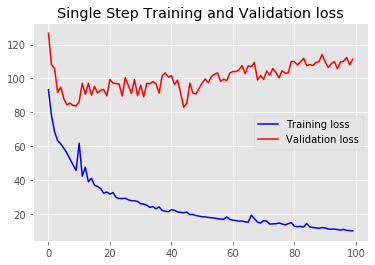

In [132]:
plot_train_history(single_step_history,
                   'Single Step Training and Validation loss')

#### Predict a single step future
Now that the model is trained, let's make a few sample predictions. The model is given the history of three features over the past n_prev weeks, and is to predict the price 1 week (3 weeks) into the future. The plot only displays the past prices. Since the prediction is made 3 weeks into the future, there is a gap between the history and prediction).

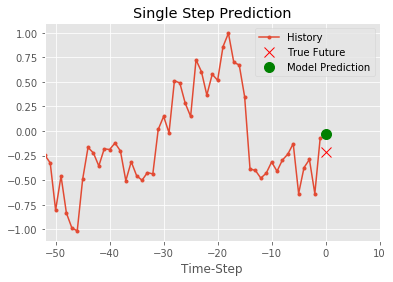

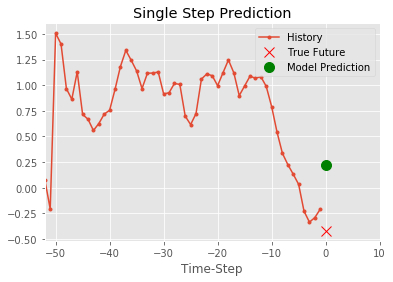

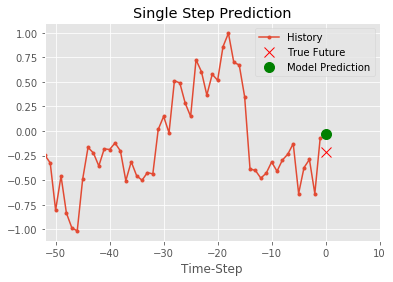

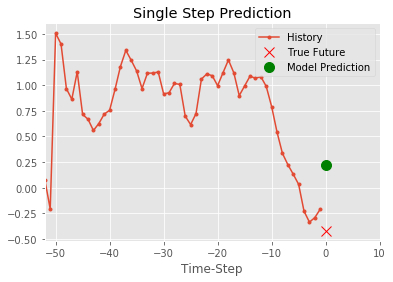

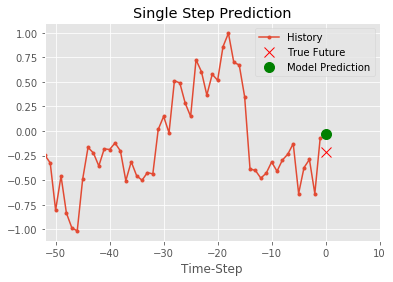

In [133]:
for x, y in val_data_single.take(5):
    plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 0,
                   'Single Step Prediction')
    plot.show()

### Multi-Step model
In a multi-step prediction model, given a past history, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predict a sequence of the future.

For the multi-step model, the training data again consists of prices over the past n_prev weeks. However, here, the model needs to learn to predict the prices for the next 3 weeks. The output is 3 predictions. For this task, the dataset needs to be prepared accordingly, thus the first step is just to create it again, but with a different target window.

In [134]:
past_history = n_prev # 52 weeks .... 720
future_target = 3 # after 3 weeks   .... 72
STEP = 1 # no gap between last observation and first prediction

x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

Let's check out a sample data-point.

In [135]:
print (x_train_multi.shape,
       y_train_multi.shape,
       'Single window of past history : {}'.format(x_train_multi[0].shape),
       'Target temperature to predict : {}'.format(y_train_multi[0].shape),
       sep='\n')

(236, 52, 3)
(236, 3)
Single window of past history : (52, 3)
Target temperature to predict : (3,)


In [136]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

Plotting a sample data-point.

In [137]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(18, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

In this plot and subsequent similar plots, the history and the future data are sampled every hour.

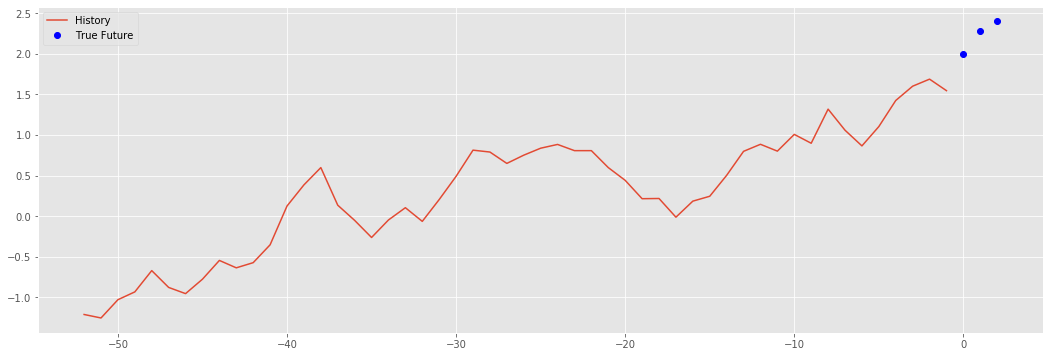

In [138]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

Since the task here is a bit more complicated than the previous task, the model now consists of two LSTM layers. Finally, since 3 predictions are made, the dense layer outputs 3 predictions.

In [139]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(3))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mape')
print(multi_step_model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 52, 32)            4608      
_________________________________________________________________
lstm_9 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 51        
Total params: 7,795
Trainable params: 7,795
Non-trainable params: 0
_________________________________________________________________
None


Let's see how the model predicts before it trains.

In [140]:
for x, y in val_data_multi.take(1):
    print (multi_step_model.predict(x).shape)

(52, 3)


In [141]:
early_stopping = EarlyStopping(monitor='val_loss', patience = 3, restore_best_weights=True)
multi_step_history = multi_step_model.fit(train_data_multi,
                                          epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=EVALUATION_INTERVAL,
                                          callbacks=[early_stopping])

Epoch 1/100
200/200 [==============================] - 7s 33ms/step - loss: 101.6008 - val_loss: 111.9376
Epoch 2/100
200/200 [==============================] - 6s 31ms/step - loss: 130.9958 - val_loss: 155.3044
Epoch 3/100
200/200 [==============================] - 6s 31ms/step - loss: 83.8532 - val_loss: 6753.2568
Epoch 4/100
200/200 [==============================] - 6s 31ms/step - loss: 71.3626 - val_loss: 122759.8906


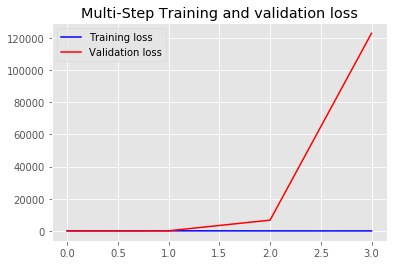

In [142]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

Predict a multi-step future
Let's now have a look at how well your network has learnt to predict the future.

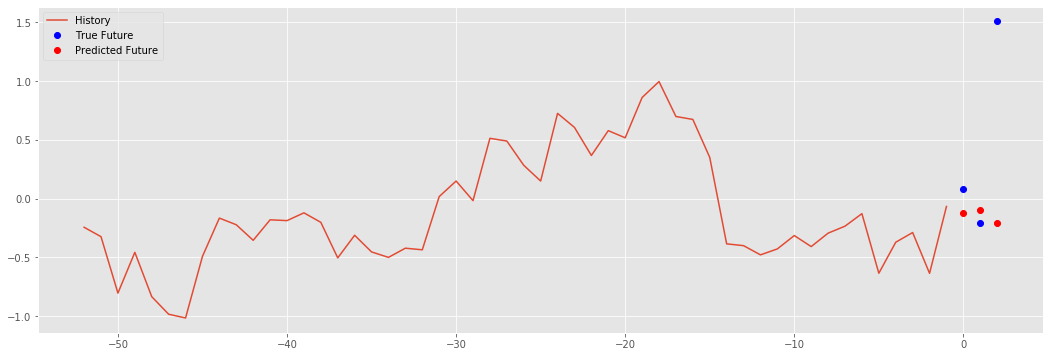

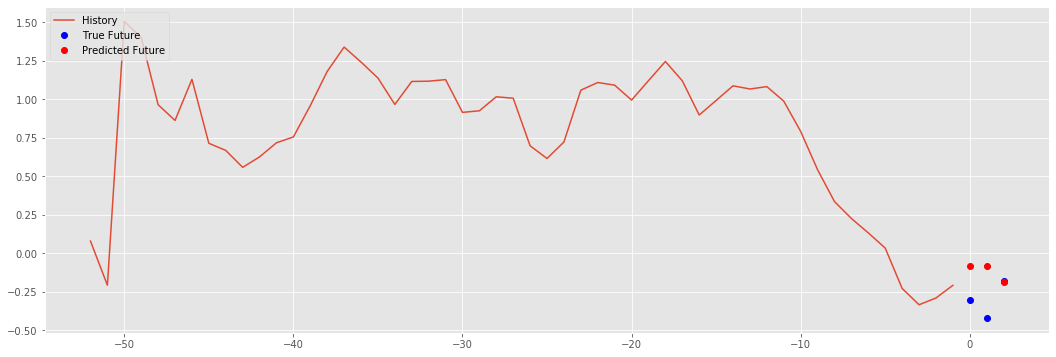

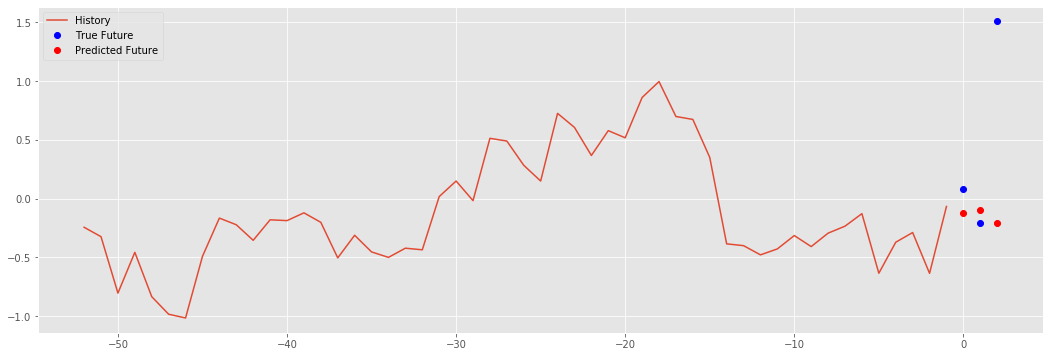

In [143]:
for x, y in val_data_multi.take(3):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

### Multi-Step, Multi-Input, and Multi-Output

In [144]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential

In [145]:
def multivariate_multioutput_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data)[:,:,:,np.newaxis,np.newaxis], np.array(labels)[:,:,:,np.newaxis,np.newaxis]

def multi_step_output_plot(history, true_future, prediction):
    plt.figure(figsize=(18, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)
    
    for i, (var, c) in enumerate(zip(features.columns[:2], ['b','r'])):
        plt.plot(num_in, np.array(history[:, i]), c, label=var)
        plt.plot(np.arange(num_out)/STEP, np.array(true_future[:,i]), c+'o', markersize=5, alpha=0.5,
               label=f"True {var.title()}")
        if prediction.any():
            plt.plot(np.arange(num_out)/STEP, np.array(prediction[:,i]), '*', markersize=5, alpha=0.5,
                     label=f"Predicted {var.title()}")
    
    plt.legend(loc='upper left')
    plt.show()

In [147]:
future_target = 3
x_train_multi, y_train_multi = multivariate_multioutput_data(dataset[:,:2], dataset[:,:2], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_multioutput_data(dataset[:,:2], dataset[:, :2],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [148]:
print (x_train_multi.shape,
       y_train_multi.shape,
       x_val_multi.shape,
       y_val_multi.shape,
       'Single window of past history : {}'.format(x_train_multi[0].shape),
       'Target temperature to predict : {}'.format(y_train_multi[0].shape),
       sep='\n')

(236, 52, 2, 1, 1)
(236, 3, 2, 1, 1)
(69, 52, 2, 1, 1)
(69, 3, 2, 1, 1)
Single window of past history : (52, 2, 1, 1)
Target temperature to predict : (3, 2, 1, 1)


In [149]:
BATCH_SIZE = 128

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

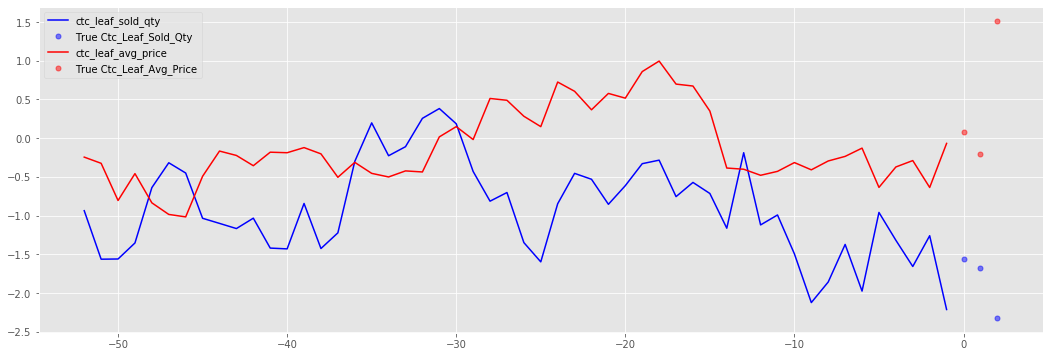

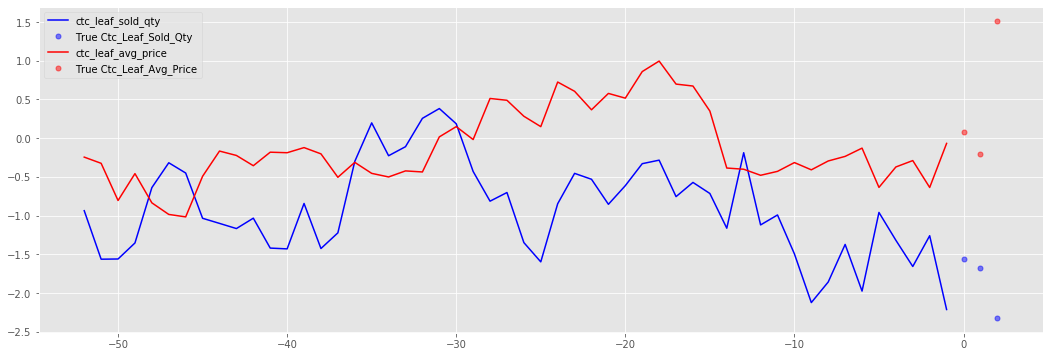

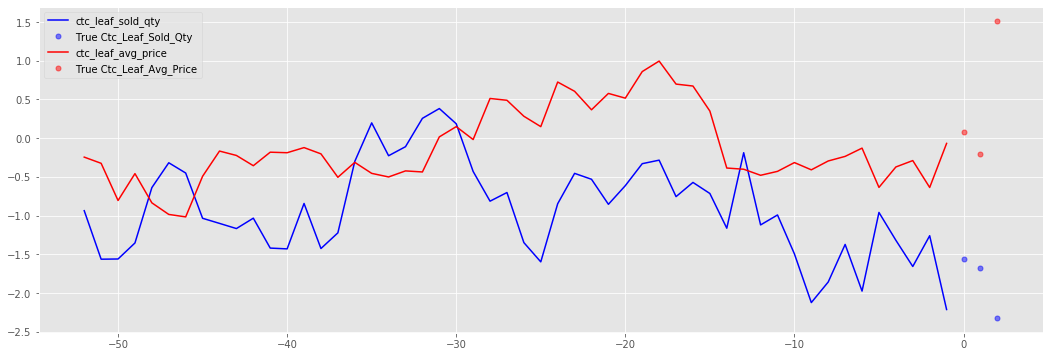

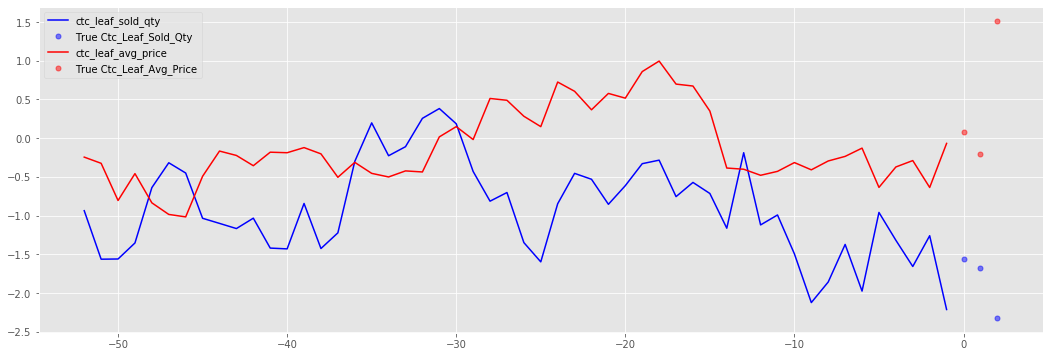

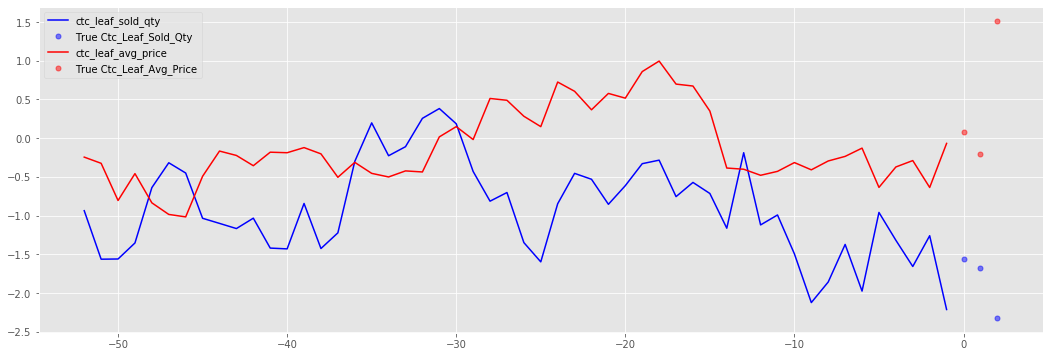

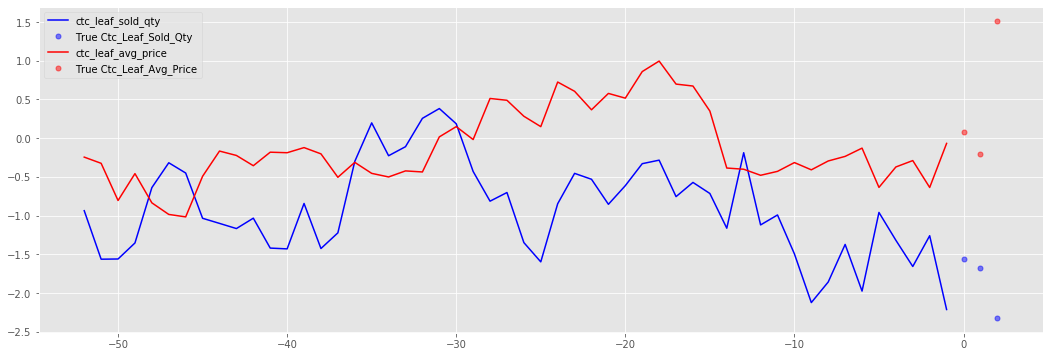

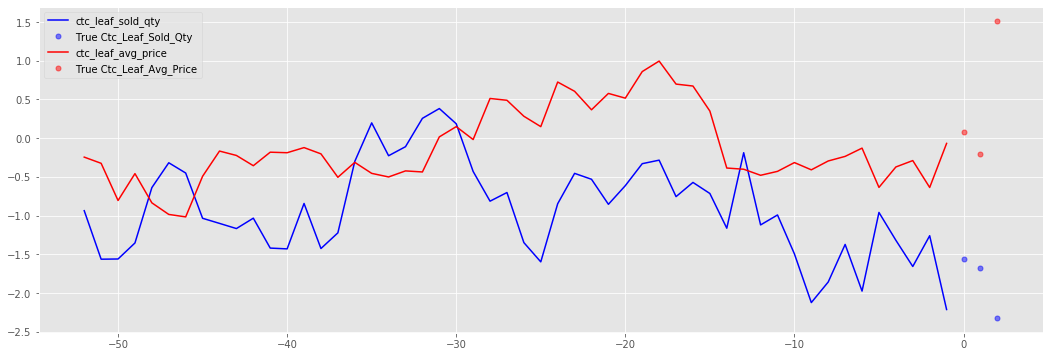

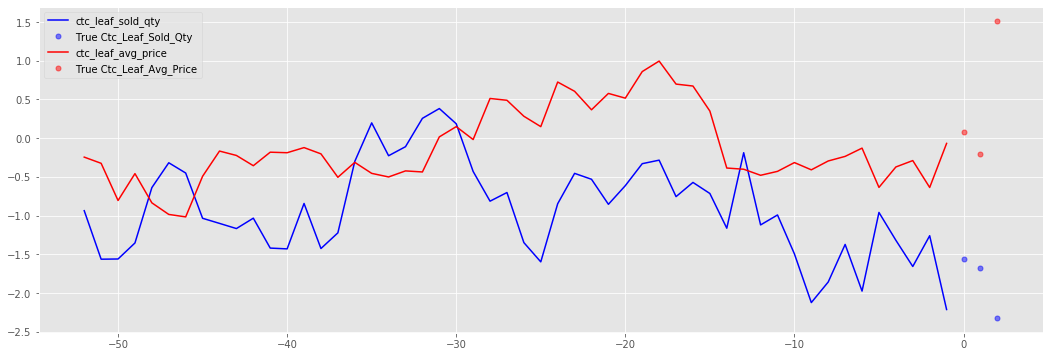

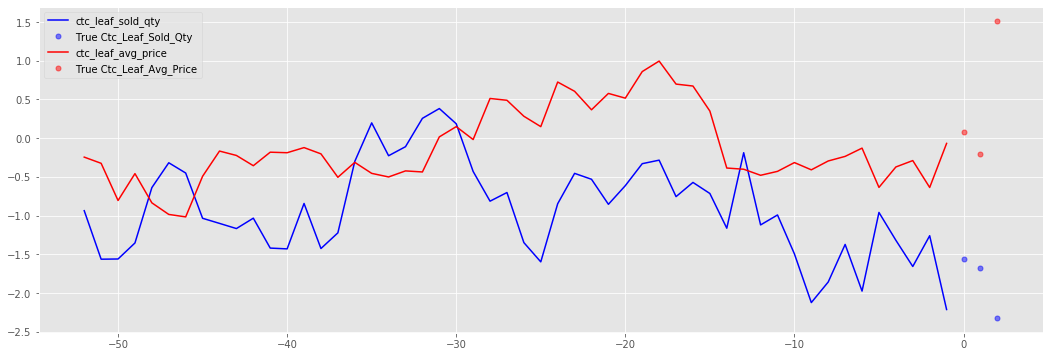

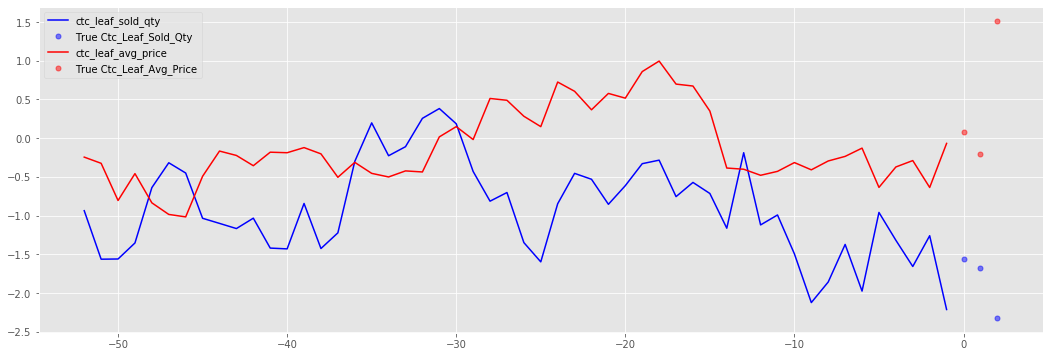

In [150]:
for x, y in val_data_multi.take(10):
    multi_step_output_plot(np.squeeze(x[0]), np.squeeze(y[0]), np.array([0]))

Convolutional LSTM
As taken from the paper.

In [151]:
def build_model(input_timesteps, output_timesteps, num_links, num_inputs):
    # COPY PASTA
    # https://github.com/niklascp/bus-arrival-convlstm/blob/master/jupyter/ConvLSTM_3x15min_10x64-5x64-10x64-5x64-Comparison.ipynb
    
    model = Sequential()
    model.add(BatchNormalization(name = 'batch_norm_0', input_shape = (input_timesteps, num_inputs, 1, 1)))
    model.add(ConvLSTM2D(name ='conv_lstm_1',
                         filters = 64, kernel_size = (10, 1),                       
                         padding = 'same', 
                         return_sequences = True))
    
    model.add(Dropout(0.30, name = 'dropout_1'))
    model.add(BatchNormalization(name = 'batch_norm_1'))

    model.add(ConvLSTM2D(name ='conv_lstm_2',
                         filters = 64, kernel_size = (5, 1), 
                         padding='same',
                         return_sequences = False))
    
    model.add(Dropout(0.20, name = 'dropout_2'))
    model.add(BatchNormalization(name = 'batch_norm_2'))
    
    model.add(Flatten())
    model.add(RepeatVector(output_timesteps))
    model.add(Reshape((output_timesteps, num_inputs, 1, 64)))
    
    model.add(ConvLSTM2D(name ='conv_lstm_3',
                         filters = 64, kernel_size = (10, 1), 
                         padding='same',
                         return_sequences = True))
    
    model.add(Dropout(0.20, name = 'dropout_3'))
    model.add(BatchNormalization(name = 'batch_norm_3'))
    
    model.add(ConvLSTM2D(name ='conv_lstm_4',
                         filters = 64, kernel_size = (5, 1), 
                         padding='same',
                         return_sequences = True))
    
    model.add(TimeDistributed(Dense(units=1, name = 'dense_1', activation = 'relu')))
    model.add(Dense(units=1, name = 'dense_2', activation = 'linear'))

#     optimizer = RMSprop() #lr=0.0001, rho=0.9, epsilon=1e-08, decay=0.9)
#     optimizer = tf.keras.optimizers.Adam(0.1)
    optimizer = tf.keras.optimizers.RMSprop(lr=0.004, clipvalue=1.0)
    model.compile(loss = "mse", optimizer = optimizer, metrics = ['mae', 'mse'])
    return model

In [152]:
future_target = 3
x_train_multi, y_train_multi = multivariate_multioutput_data(dataset[:,:2], dataset[:,:2], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_multioutput_data(dataset[:,:2], dataset[:, :2],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

BATCH_SIZE = 128

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [155]:
import time
EPOCHS = 40
steps_per_epoch = 350
validation_steps = 500

modelstart = time.time()
early_stopping = EarlyStopping(monitor='val_loss', patience = PATIENCE, restore_best_weights=True)
model = build_model(x_train_multi.shape[1], future_target, y_train_multi.shape[2], x_train_multi.shape[2])
print(model.summary())

# Train
print("\nTRAIN MODEL...")
history = model.fit(train_data_multi,
                    epochs = EPOCHS,
                    validation_data=val_data_multi,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    verbose=1,
                    callbacks=[early_stopping])
model.save('multi-output-timesteps.h5')
print("\nModel Runtime: %0.2f Minutes"%((time.time() - modelstart)/60))

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_norm_0 (BatchNormaliza (None, 52, 2, 1, 1)       4         
_________________________________________________________________
conv_lstm_1 (ConvLSTM2D)     (None, 52, 2, 1, 64)      166656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 52, 2, 1, 64)      0         
_________________________________________________________________
batch_norm_1 (BatchNormaliza (None, 52, 2, 1, 64)      256       
_________________________________________________________________
conv_lstm_2 (ConvLSTM2D)     (None, 2, 1, 64)          164096    
_________________________________________________________________
dropout_2 (Dropout)          (None, 2, 1, 64)          0         
_________________________________________________________________
batch_norm_2 (BatchNormaliza (None, 2, 1, 64)         

Epoch 35/40
350/350 [==============================] - 67s 191ms/step - loss: 0.0174 - mae: 0.0645 - mse: 0.0174 - val_loss: 0.9624 - val_mae: 0.7718 - val_mse: 0.9624
Epoch 36/40
350/350 [==============================] - 67s 191ms/step - loss: 0.0049 - mae: 0.0393 - mse: 0.0049 - val_loss: 1.0084 - val_mae: 0.7971 - val_mse: 1.0084
Epoch 37/40
350/350 [==============================] - 67s 191ms/step - loss: 0.0063 - mae: 0.0408 - mse: 0.0063 - val_loss: 1.0596 - val_mae: 0.7945 - val_mse: 1.0596
Epoch 38/40
350/350 [==============================] - 67s 191ms/step - loss: 0.0034 - mae: 0.0343 - mse: 0.0034 - val_loss: 1.3871 - val_mae: 0.9688 - val_mse: 1.3870
Epoch 39/40
350/350 [==============================] - 67s 191ms/step - loss: 0.0020 - mae: 0.0323 - mse: 0.0020 - val_loss: 1.0993 - val_mae: 0.8300 - val_mse: 1.0993
Epoch 40/40
350/350 [==============================] - 67s 190ms/step - loss: 0.0018 - mae: 0.0318 - mse: 0.0018 - val_loss: 0.9710 - val_mae: 0.7484 - val_mse:

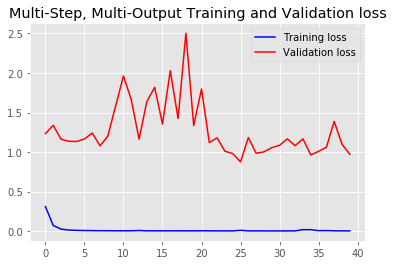

In [156]:
plot_train_history(history, 'Multi-Step, Multi-Output Training and Validation loss')

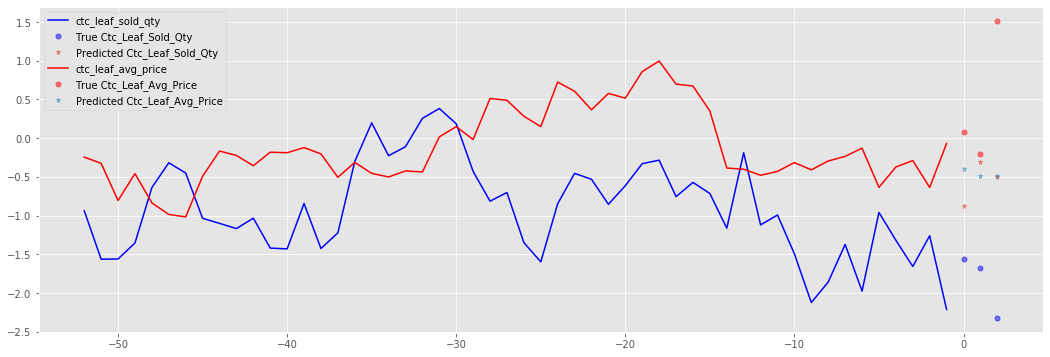

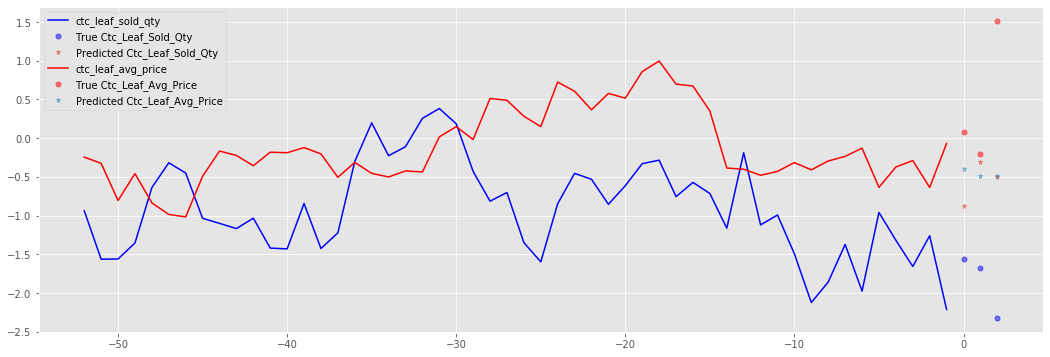

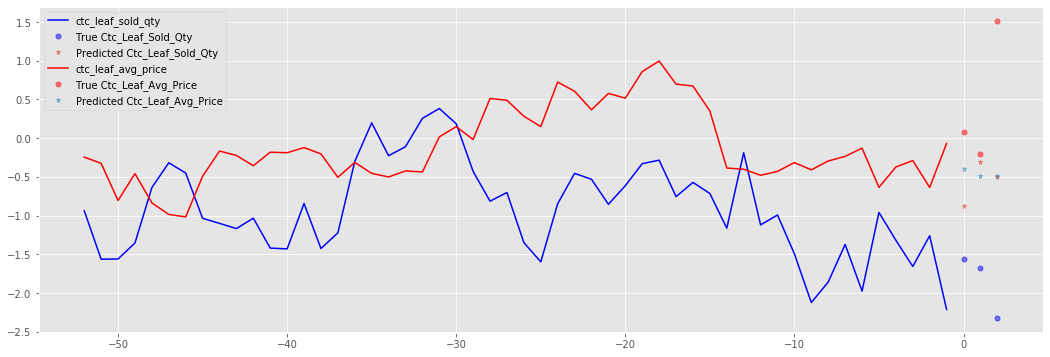

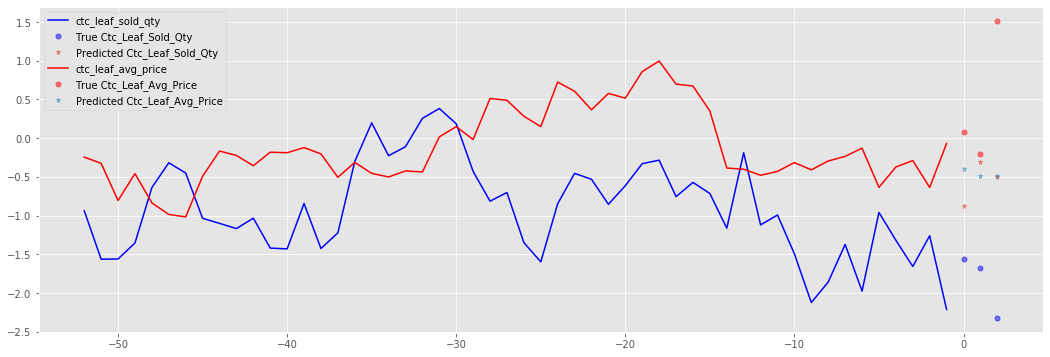

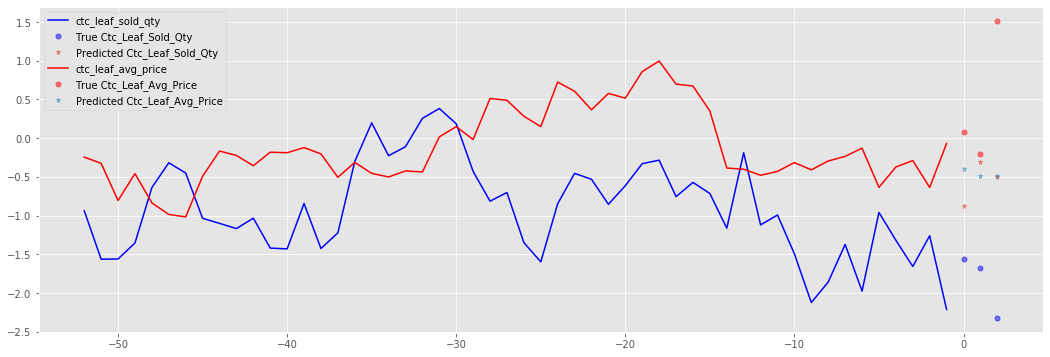

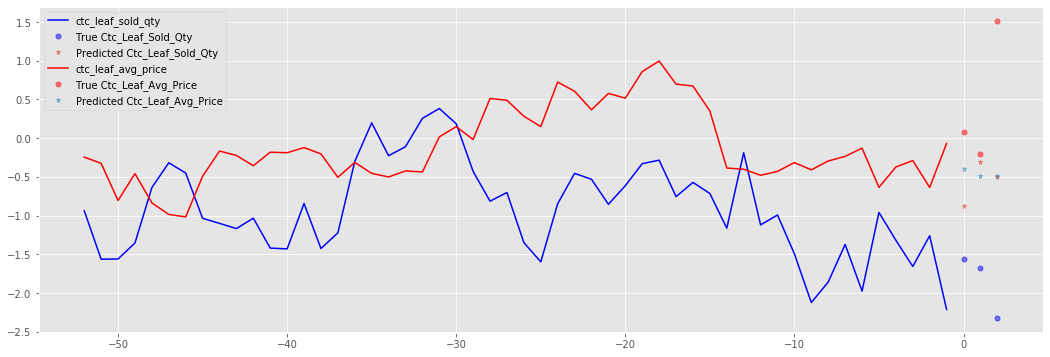

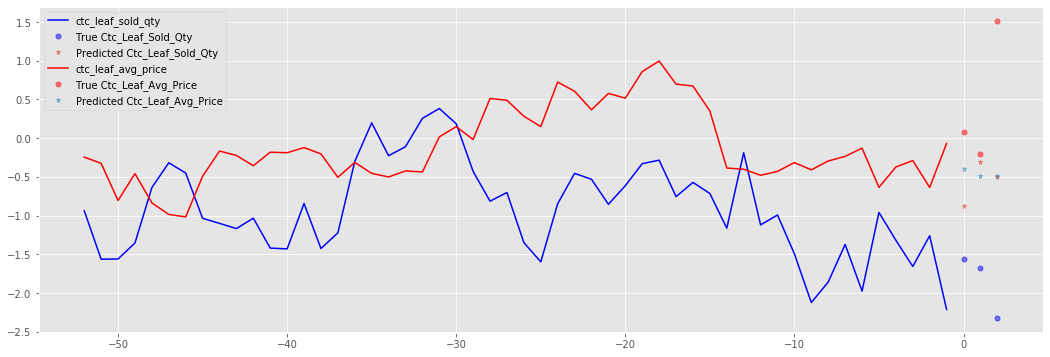

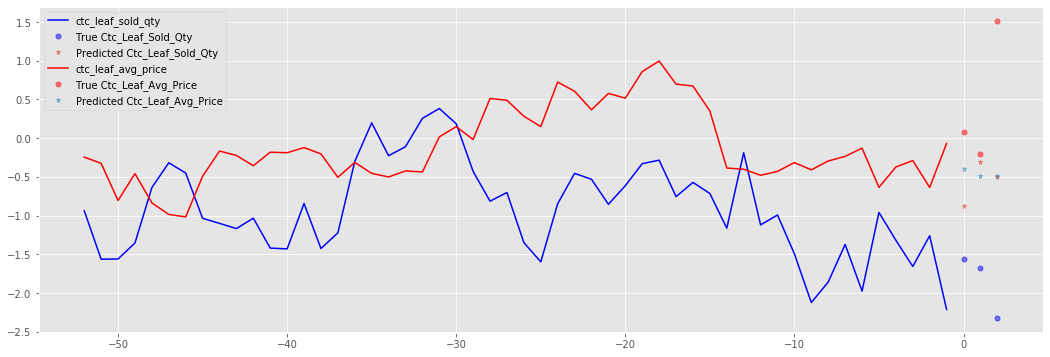

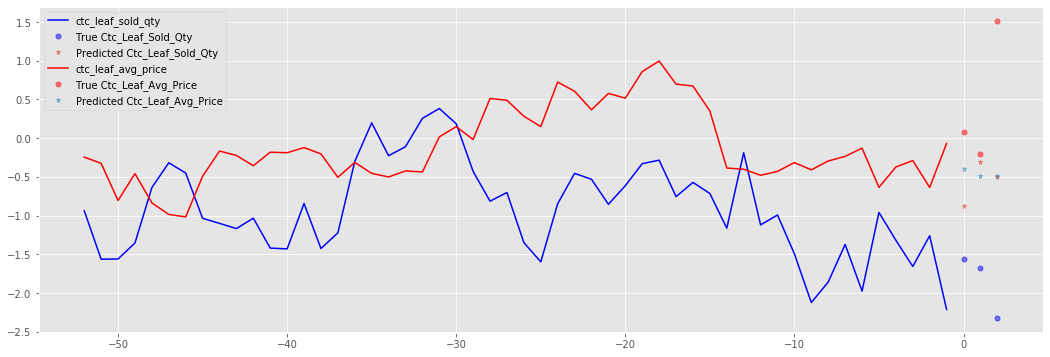

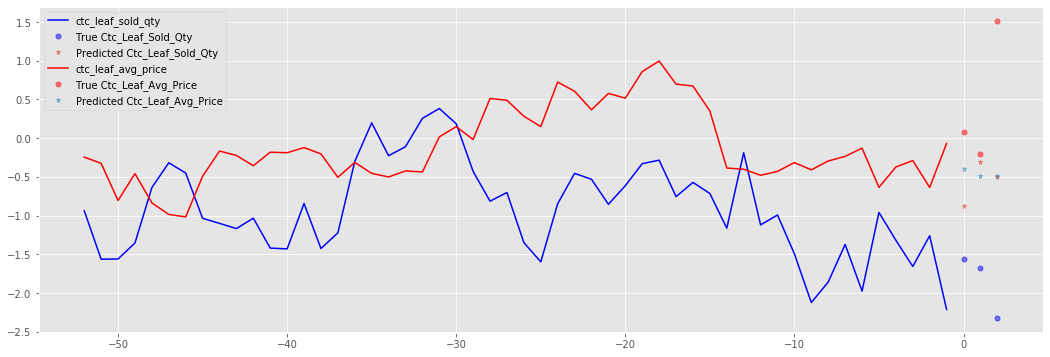

In [157]:
for x, y in val_data_multi.take(10):
    multi_step_output_plot(np.squeeze(x[0]), np.squeeze(y[0]), np.squeeze(model.predict(x[0][np.newaxis,:,:,:,:])))

#### Now simplifying the Convolutional LSTM

In [158]:
def build_model(input_timesteps, output_timesteps, num_links, num_inputs):    
    model = Sequential()
    model.add(BatchNormalization(name = 'batch_norm_0', input_shape = (input_timesteps, num_inputs, 1, 1)))
    model.add(ConvLSTM2D(name ='conv_lstm_1',
                         filters = 64, kernel_size = (10, 1),                       
                         padding = 'same', 
                         return_sequences = False))
    
    model.add(Dropout(0.30, name = 'dropout_1'))
    model.add(BatchNormalization(name = 'batch_norm_1'))

#     model.add(ConvLSTM2D(name ='conv_lstm_2',
#                          filters = 64, kernel_size = (5, 1), 
#                          padding='same',
#                          return_sequences = False))
    
#     model.add(Dropout(0.20, name = 'dropout_2'))
#     model.add(BatchNormalization(name = 'batch_norm_2'))
    
    model.add(Flatten())
    model.add(RepeatVector(output_timesteps))
    model.add(Reshape((output_timesteps, num_inputs, 1, 64)))
    
#     model.add(ConvLSTM2D(name ='conv_lstm_3',
#                          filters = 64, kernel_size = (10, 1), 
#                          padding='same',
#                          return_sequences = True))
    
#     model.add(Dropout(0.20, name = 'dropout_3'))
#     model.add(BatchNormalization(name = 'batch_norm_3'))
    
    model.add(ConvLSTM2D(name ='conv_lstm_4',
                         filters = 64, kernel_size = (5, 1), 
                         padding='same',
                         return_sequences = True))
    
    model.add(TimeDistributed(Dense(units=1, name = 'dense_1', activation = 'relu')))
    model.add(Dense(units=1, name = 'dense_2'))

#     optimizer = RMSprop() #lr=0.0001, rho=0.9, epsilon=1e-08, decay=0.9)
#     optimizer = tf.keras.optimizers.Adam(0.1)
    optimizer = tf.keras.optimizers.RMSprop(lr=0.003, clipvalue=1.0)
    model.compile(loss = "mse", optimizer = optimizer, metrics = ['mae', 'mse'])
    return model

In [159]:
# Extend Prediction Window..
future_target = 6
x_train_multi, y_train_multi = multivariate_multioutput_data(dataset[:,:2], dataset[:,:2], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_multioutput_data(dataset[:,:2], dataset[:, :2],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

BATCH_SIZE = 128

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [160]:
EPOCHS = 30
steps_per_epoch = 350
validation_steps = 500

modelstart = time.time()
early_stopping = EarlyStopping(monitor='val_loss', patience = PATIENCE, restore_best_weights=True)
model = build_model(x_train_multi.shape[1], future_target, y_train_multi.shape[2], x_train_multi.shape[2])
print(model.summary())

# Train
print("\nTRAIN MODEL...")
history = model.fit(train_data_multi,
                    epochs = EPOCHS,
                    validation_data=val_data_multi,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    verbose=1,
                    callbacks=[early_stopping])
model.save('multi-output-timesteps.h5')
print("\nModel Runtime: %0.2f Minutes"%((time.time() - modelstart)/60))

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_norm_0 (BatchNormaliza (None, 52, 2, 1, 1)       4         
_________________________________________________________________
conv_lstm_1 (ConvLSTM2D)     (None, 2, 1, 64)          166656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 1, 64)          0         
_________________________________________________________________
batch_norm_1 (BatchNormaliza (None, 2, 1, 64)          256       
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 6, 128)            0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 6, 2, 1, 64)      

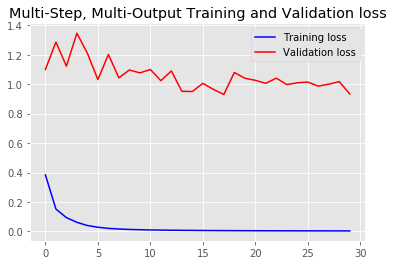

In [161]:
plot_train_history(history, 'Multi-Step, Multi-Output Training and Validation loss')

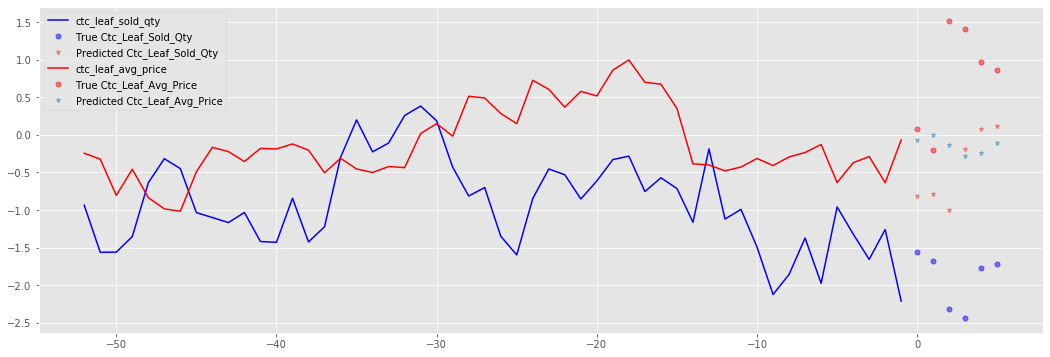

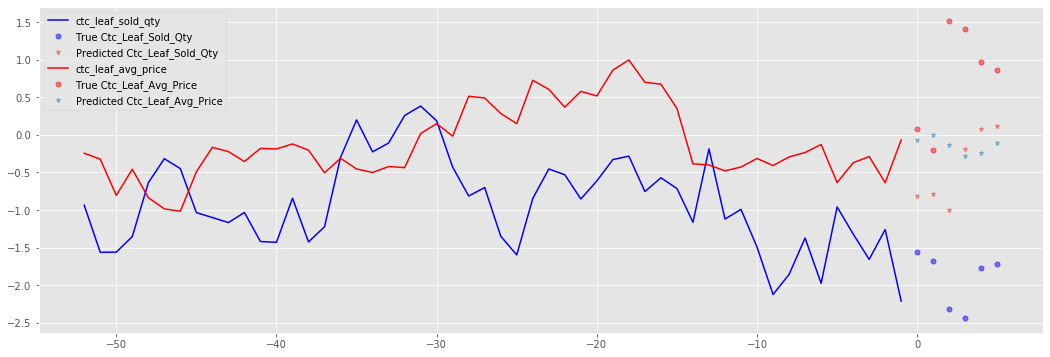

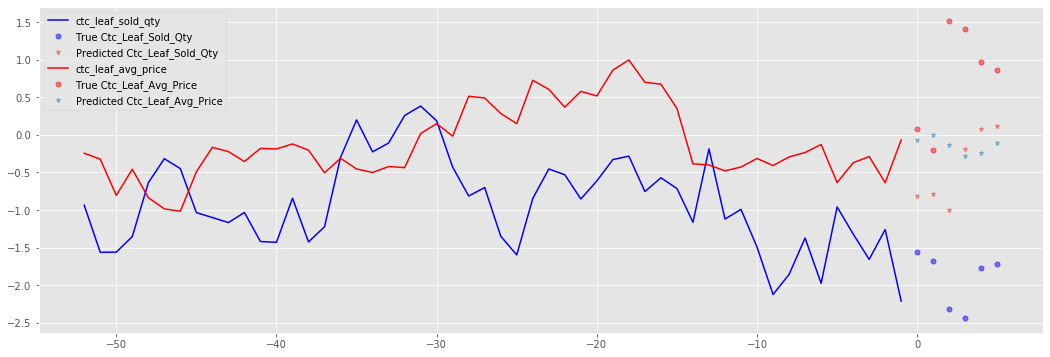

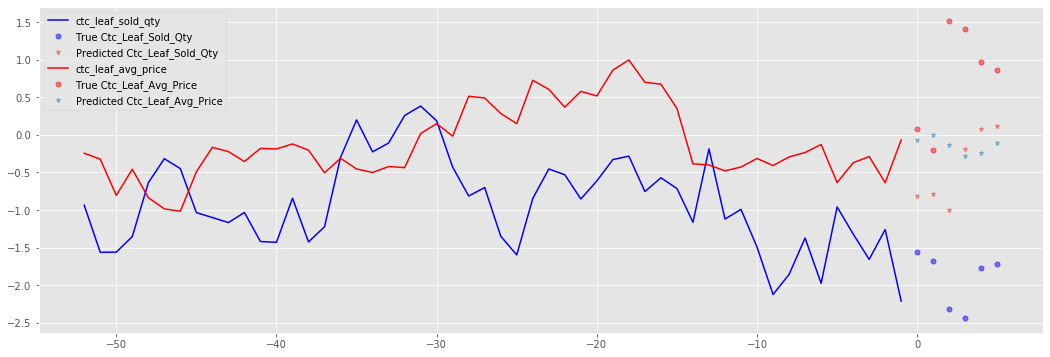

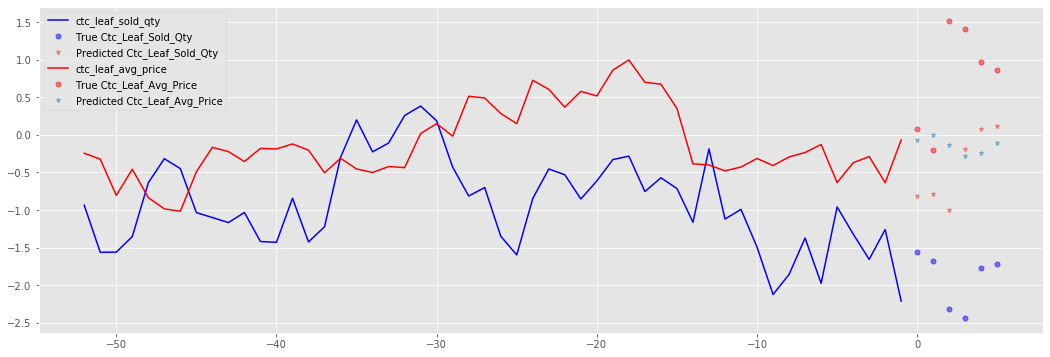

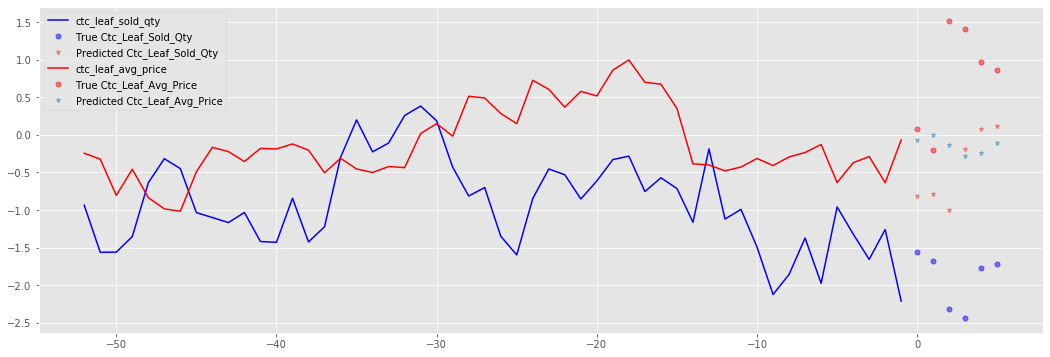

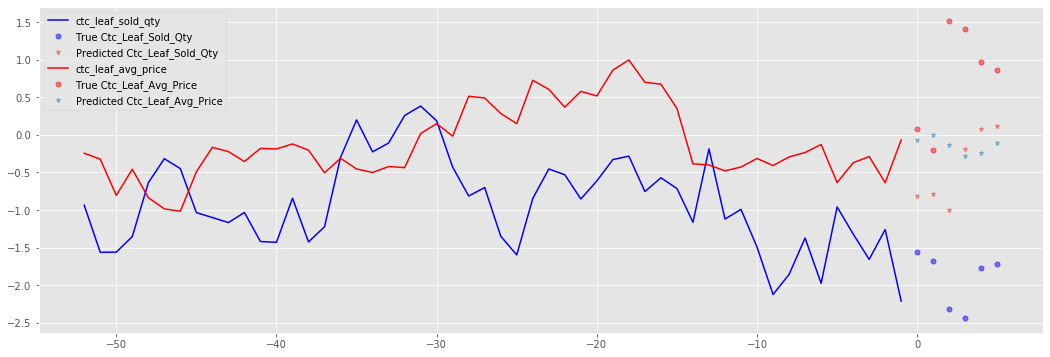

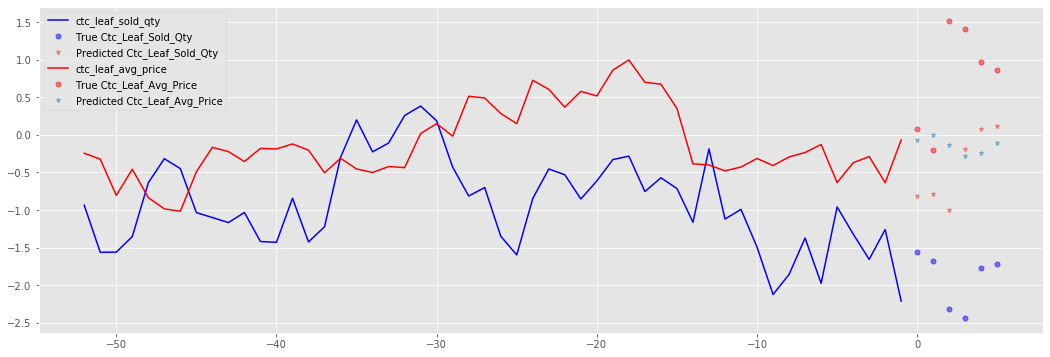

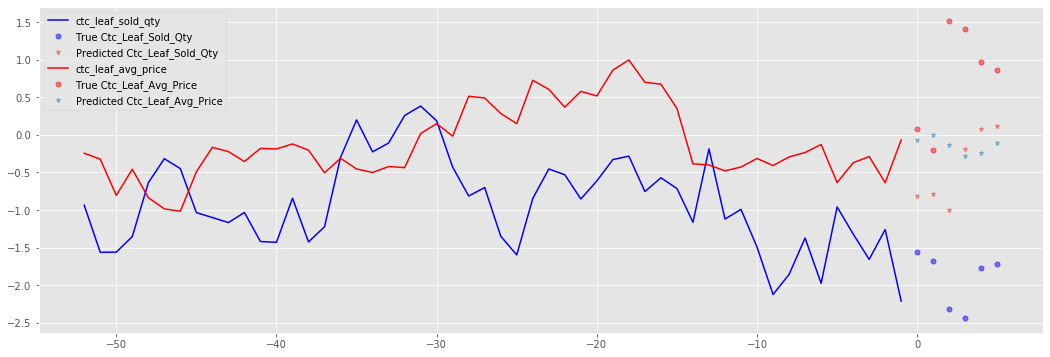

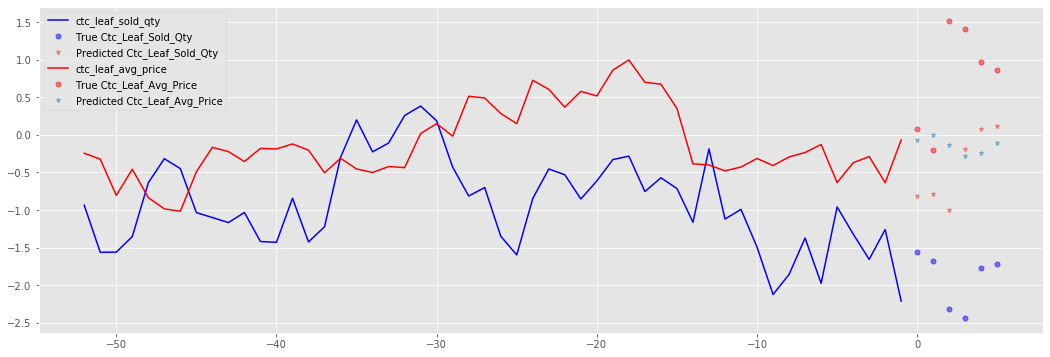

In [162]:
for x, y in val_data_multi.take(10):
    multi_step_output_plot(np.squeeze(x[0]), np.squeeze(y[0]), np.squeeze(model.predict(x[0][np.newaxis,:,:,:,:])))